# Analysis of data downloaded from Thingspeak
The data is home temperature/humidity readings from 2019 to 2024

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip
import io
import datetime
from typing import List
from scipy.stats import ks_2samp
import numpy as np

In [137]:
# The csv file was downloaded from the Thingspeak website.  It contains sensor readings from the time the temperature sensors were first installed until today.
# Read the CSV file into a DataFrame
file_path = 'data/iotitan_thingspeak_20241227.csv'
with open(file_path, 'rt') as f:
    #df = pd.read_csv(f, header=0, nrows=10000)
    df = pd.read_csv(f, header=0)

In [138]:
df.head(10)

created_at  entry_id  field1  field2  field3  field4  \
0  2019-04-07T15:14:10+00:00         1     NaN     NaN     NaN     NaN   
1  2019-04-07T15:15:11+00:00         2     NaN     NaN     NaN     NaN   
2  2019-04-07T15:16:12+00:00         3     NaN     NaN     NaN     NaN   
3  2019-04-07T15:17:12+00:00         4     NaN     NaN     NaN     NaN   
4  2019-04-07T15:18:13+00:00         5     NaN     NaN     NaN     NaN   
5  2019-04-07T15:19:14+00:00         6     NaN     NaN     NaN     NaN   
6  2019-04-07T15:20:15+00:00         7     NaN    23.0    52.0     NaN   
7  2019-04-07T15:21:16+00:00         8     NaN    23.0    52.0     NaN   
8  2019-04-07T15:22:17+00:00         9    23.0    52.0     NaN     NaN   
9  2019-04-07T15:23:17+00:00        10    23.0    52.0     NaN     NaN   

   field5  field6  field7  latitude  longitude  elevation  status  
0     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
1     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
2     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
3     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
4     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
5     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
6     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
7     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
8     NaN     NaN     NaN       NaN        NaN        NaN     NaN  
9     NaN     NaN     NaN       NaN        NaN        NaN     NaN

In [139]:
#test = df.head(10)
#print(test)
#test['created_at'] = pd.to_datetime(test['created_at']).dt.tz_convert('Australia/Adelaide')
#print(test)

In [140]:
# there are 7 columns named field1, field2, ...  Rename them.
df.rename(columns={'field1': 'up_bed1_temperature', 'field2': 'up_bed1_humidity', 'field3': 'up_bed1_pir', 'field4': 'up_bed4_temperature', 'field5': 'up_bed4_humidity', 'field6': 'down_temperature', 'field7': 'down_humidity'}, inplace=True)

In [141]:
# df[100:110]

In [142]:
sensor_names = ['up_bed1_temperature', 'up_bed1_humidity', 'up_bed1_pir', 'up_bed4_temperature', 'up_bed4_humidity', 'down_temperature', 'down_humidity']

In [143]:
# I checked, and the logging device timezone is set to UTC.  So all input times are UTC
# Convert the 'created_at' column to datetime format, and create additional columns
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_convert('Australia/Adelaide')
# Create a new 'year' column from the 'timestamp' column
df['year'] = pd.DatetimeIndex(df['created_at']).year
# Create a new 'month' column from the 'timestamp' column
df['month'] = pd.DatetimeIndex(df['created_at']).month
# Create a new 'day' column from the 'timestamp' column indicating the numeric day-of-month
df['day'] = pd.DatetimeIndex(df['created_at']).day
df['hour'] = pd.DatetimeIndex(df['created_at']).hour
# Create a new column 'day_of_year' which is the day of the year the sensor value was observed
df['day_of_year'] = df['created_at'].dt.dayofyear
df['time_of_day'] = df['created_at'].apply(lambda x: x.replace(year=1990, month=1, day=1)) #.dt.time

In [144]:
# ensure all sensor values are numeric
for sensor_name in sensor_names:
    df[sensor_name] = pd.to_numeric(df[sensor_name], errors='coerce')

In [145]:
# explore the data
df.describe()

entry_id  up_bed1_temperature  up_bed1_humidity    up_bed1_pir  \
count  3.024898e+06        491258.000000     534045.000000  479796.000000   
mean   1.512450e+06            22.063466         46.483561       0.365075   
std    8.732130e+05             3.666171         10.062300       0.253157   
min    1.000000e+00            10.700000          7.400000       0.000000   
25%    7.562252e+05            19.200000         39.700000       0.000000   
50%    1.512450e+06            21.700000         47.000000       0.488889   
75%    2.268674e+06            24.400000         53.800000       0.500000   
max    3.024898e+06            42.000000         95.000000      52.000000   

       up_bed4_temperature  up_bed4_humidity  down_temperature  down_humidity  \
count        356040.000000     232515.000000     470292.000000  469046.000000   
mean             21.478549         56.698321         19.910181      53.348978   
std               3.329973         11.449256          3.234419      10.485330   
min              13.800000         17.000000         12.600000      23.530000   
25%              19.000000         49.000000         17.300000      46.520000   
50%              21.000000         57.700000         19.590000      51.850000   
75%              24.000000         64.600000         22.165227      58.460000   
max              34.200000         94.000000         33.500000      99.900000   

       latitude  longitude  elevation  status          year         month  \
count       0.0        0.0        0.0     0.0  3.024898e+06  3.024898e+06   
mean        NaN        NaN        NaN     NaN  2.021609e+03  6.728372e+00   
std         NaN        NaN        NaN     NaN  1.700590e+00  3.396302e+00   
min         NaN        NaN        NaN     NaN  2.019000e+03  1.000000e+00   
25%         NaN        NaN        NaN     NaN  2.020000e+03  4.000000e+00   
50%         NaN        NaN        NaN     NaN  2.022000e+03  7.000000e+00   
75%         NaN        NaN        NaN     NaN  2.023000e+03  1.000000e+01   
max         NaN        NaN        NaN     NaN  2.024000e+03  1.200000e+01   

                day          hour   day_of_year  
count  3.024898e+06  3.024898e+06  3.024898e+06  
mean   1.581039e+01  1.150502e+01  1.895608e+02  
std    8.797777e+00  6.920110e+00  1.037069e+02  
min    1.000000e+00  0.000000e+00  1.000000e+00  
25%    8.000000e+00  6.000000e+00  1.060000e+02  
50%    1.600000e+01  1.200000e+01  1.910000e+02  
75%    2.300000e+01  1.700000e+01  2.790000e+02  
max    3.100000e+01  2.300000e+01  3.660000e+02

In [146]:
df['year'].nunique()

6

In [147]:
df['year'].value_counts()

year
2020    587775
2023    549733
2024    548949
2022    504571
2021    423989
2019    409881
Name: count, dtype: int64

In [148]:
# These plots do not work - too much data?
# Create time series plots for each sensor (column)
#plt.figure(figsize=(15, 10))
#for sensor_name in sensor_names:
#    #if sensor_name == 'up_bed1_temperature':
#    plt.plot(df['created_at'], df[sensor_name], label=sensor_name, alpha=0.7)
#    plt.xlabel('Time')
#    plt.ylabel(sensor_name)
#    plt.title(f"{sensor_name} Over Time")
#    plt.legend()
#    plt.show()

So there seems to be a lot of missing data.  Check for one sensor the distibution of data.

In [149]:
years = df['year'].unique()
print(years)
for year in years:
    year_data = df[df['year'] == year]
    print(year_data['up_bed1_temperature'].describe())

[2019 2020 2021 2022 2023 2024]
count    69337.000000
mean        20.142512
std          3.858574
min         10.700000
25%         17.400000
50%         19.000000
75%         22.300000
max         35.700000
Name: up_bed1_temperature, dtype: float64
count    87005.000000
mean        21.747305
std          3.184369
min         14.600000
25%         19.200000
50%         21.100000
75%         23.900000
max         39.100000
Name: up_bed1_temperature, dtype: float64
count    86851.000000
mean        22.623899
std          3.223224
min         15.100000
25%         20.100000
50%         22.400000
75%         24.727273
max         36.100000
Name: up_bed1_temperature, dtype: float64
count    86075.000000
mean        21.678813
std          3.647276
min         14.000000
25%         18.900000
50%         21.100000
75%         23.700000
max         39.200000
Name: up_bed1_temperature, dtype: float64
count    83401.000000
mean        22.715782
std          3.249224
min         14.200000
25%     

so for this sensor, the data seems complete.
There are about 80,000 readings per year, which is about 230 readings a day, which is about 10 readings an hour, or once every 6 minutes.

In [150]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [151]:
#create dataframes with 1 reading per day.  Separate df for max, min, avg for each sensor
for sensor_name in sensor_names:
    df_avg = df.groupby(['year','day_of_year'])[sensor_name].mean().reset_index()
    locals()[f'df_avg_{sensor_name}'] = df_avg
    df_max = df.groupby(['year','day_of_year'])[sensor_name].max().reset_index()
    locals()[f'df_max_{sensor_name}'] = df_max
    df_min = df.groupby(['year','day_of_year'])[sensor_name].min().reset_index()
    locals()[f'df_min_{sensor_name}'] = df_min
    df_hourly = df.groupby(['year','month','day','day_of_year','hour'])[sensor_name].mean().reset_index()
    locals()[f'df_hourly_{sensor_name}'] = df_hourly

In [152]:
df_avg_up_bed1_temperature.head(5)

year  day_of_year  up_bed1_temperature
0  2019           98            21.103203
1  2019           99            20.256944
2  2019          100            17.985075
3  2019          106            24.089524
4  2019          107            23.563509

In [153]:
years = df['year'].unique()

# AVERAGE DAILY VALUES

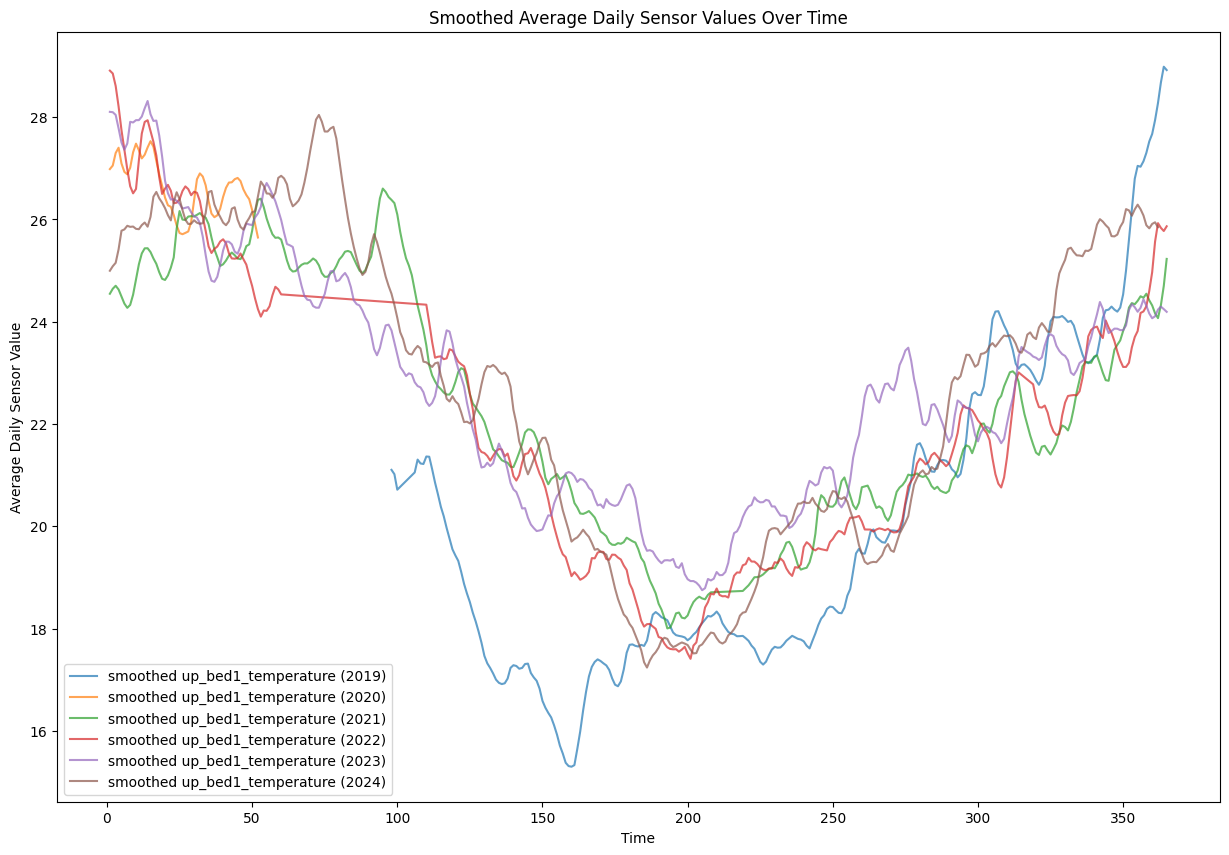

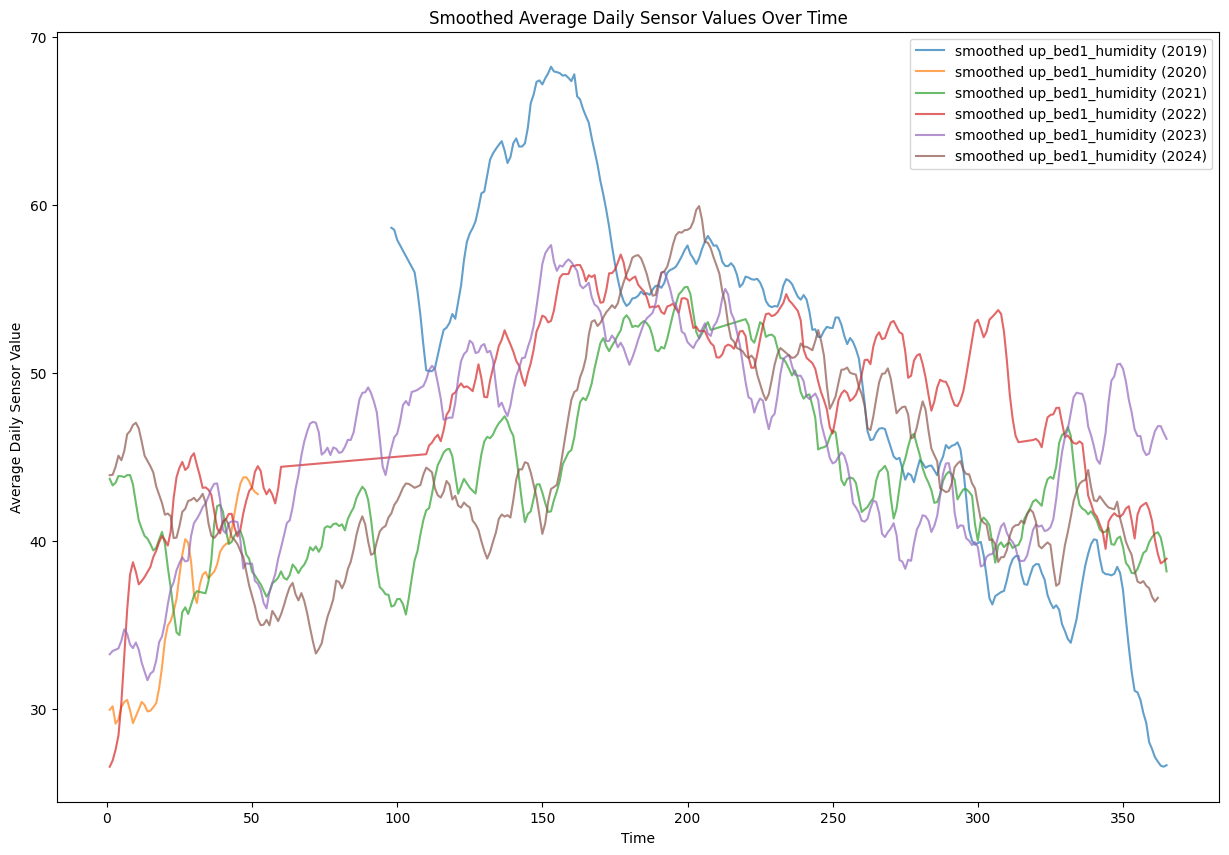

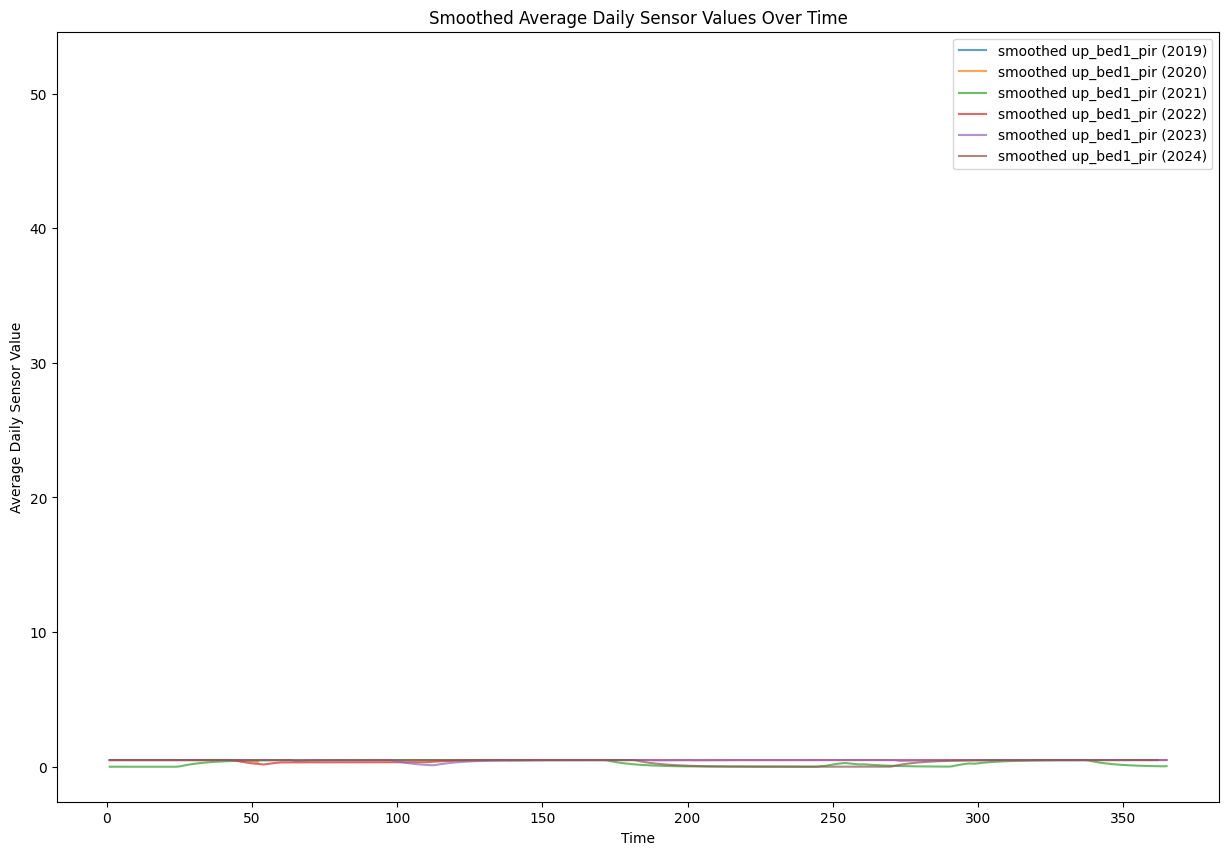

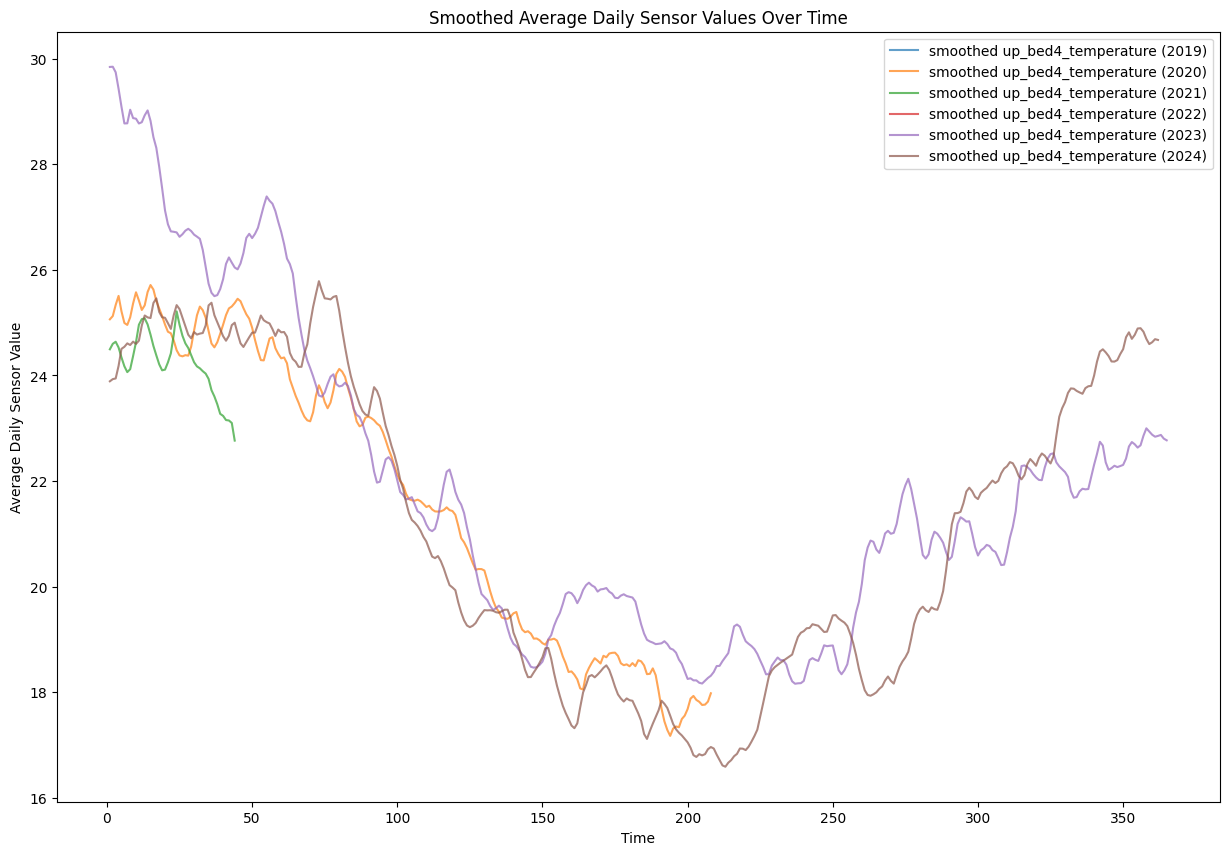

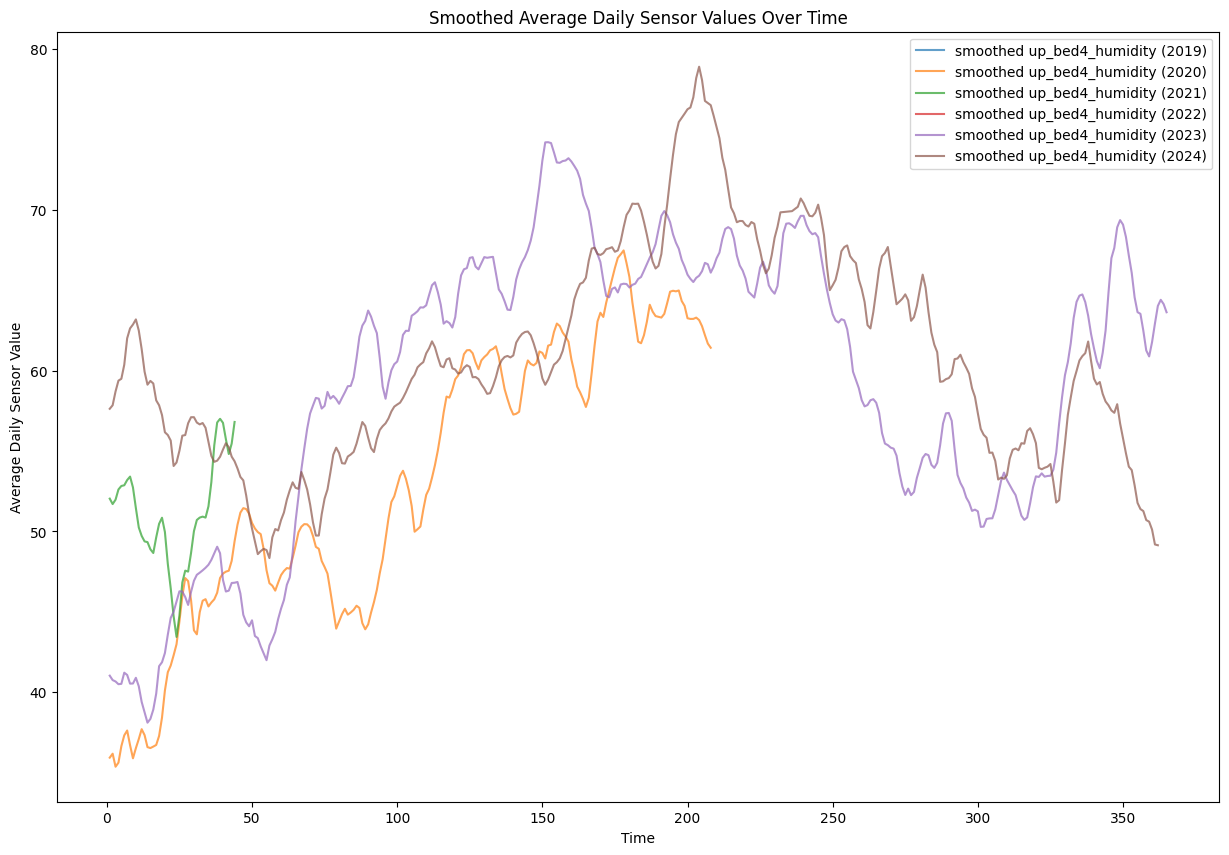

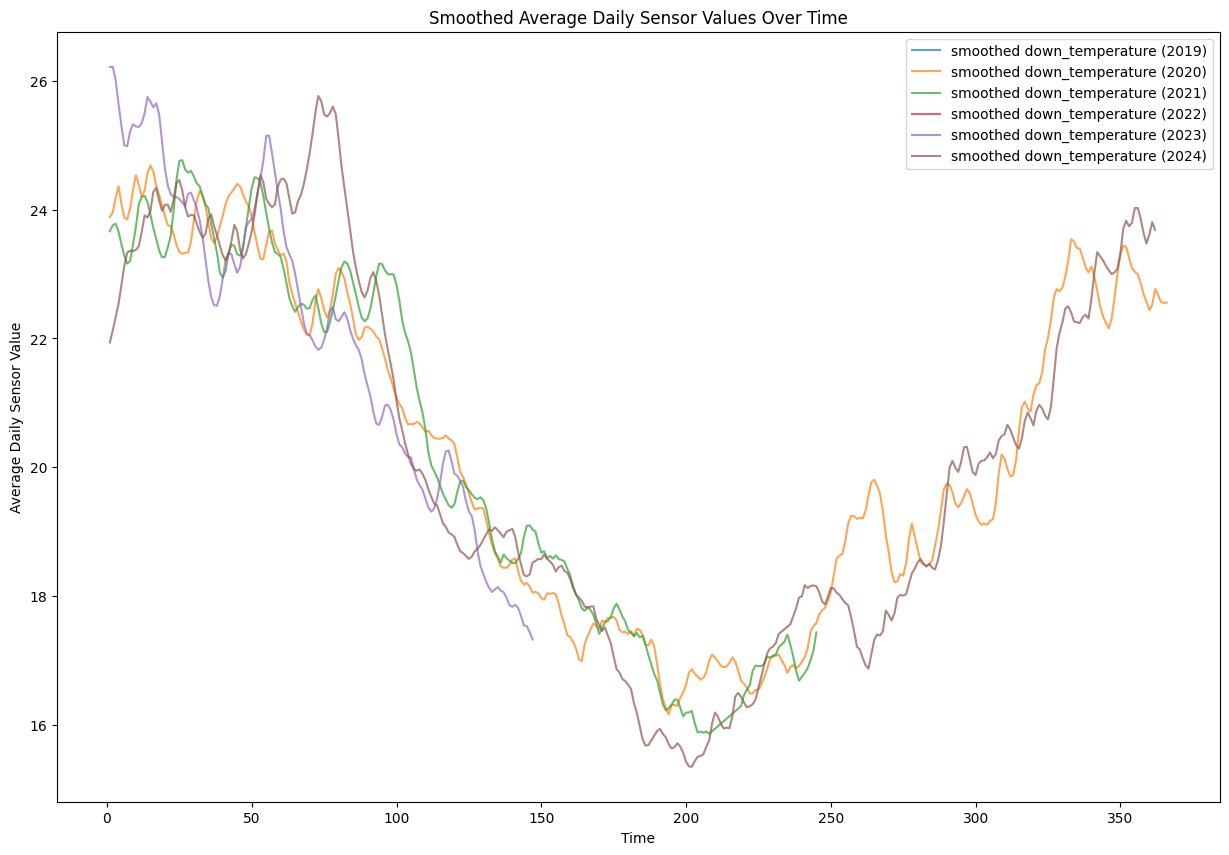

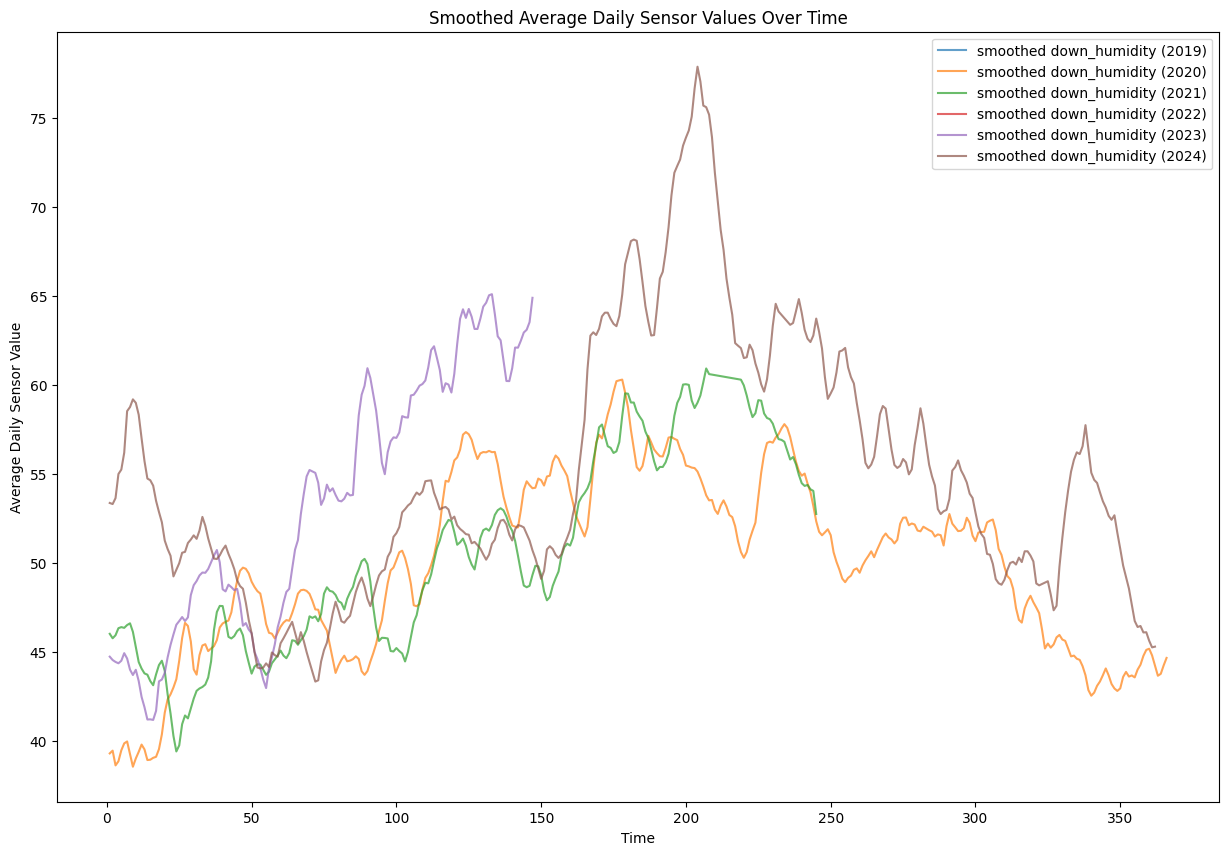

In [154]:
for sensor_name in sensor_names:
    #if ('up_bed1_temperature' in sensor_name):
    adf = locals()[f'df_avg_{sensor_name}']
    plt.figure(figsize=(15, 10))
    for year in years:
        year_data = adf[adf['year'] == year]
        year_values_ordered = year_data.sort_values(by=['day_of_year'], ascending=True)[sensor_name].to_list()
        year_values_smoothed = smooth(year_values_ordered, 0.9)
        #plt.plot(year_data['day_of_year'], year_values_ordered, label=f"{sensor_name} ({year})", alpha=0.7)
        plt.plot(year_data['day_of_year'], year_values_smoothed, label=f"smoothed {sensor_name} ({year})", alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Average Daily Sensor Value')
    plt.title('Smoothed Average Daily Sensor Values Over Time')
    plt.legend()
    plt.show()

# MAX DAILY VALUES

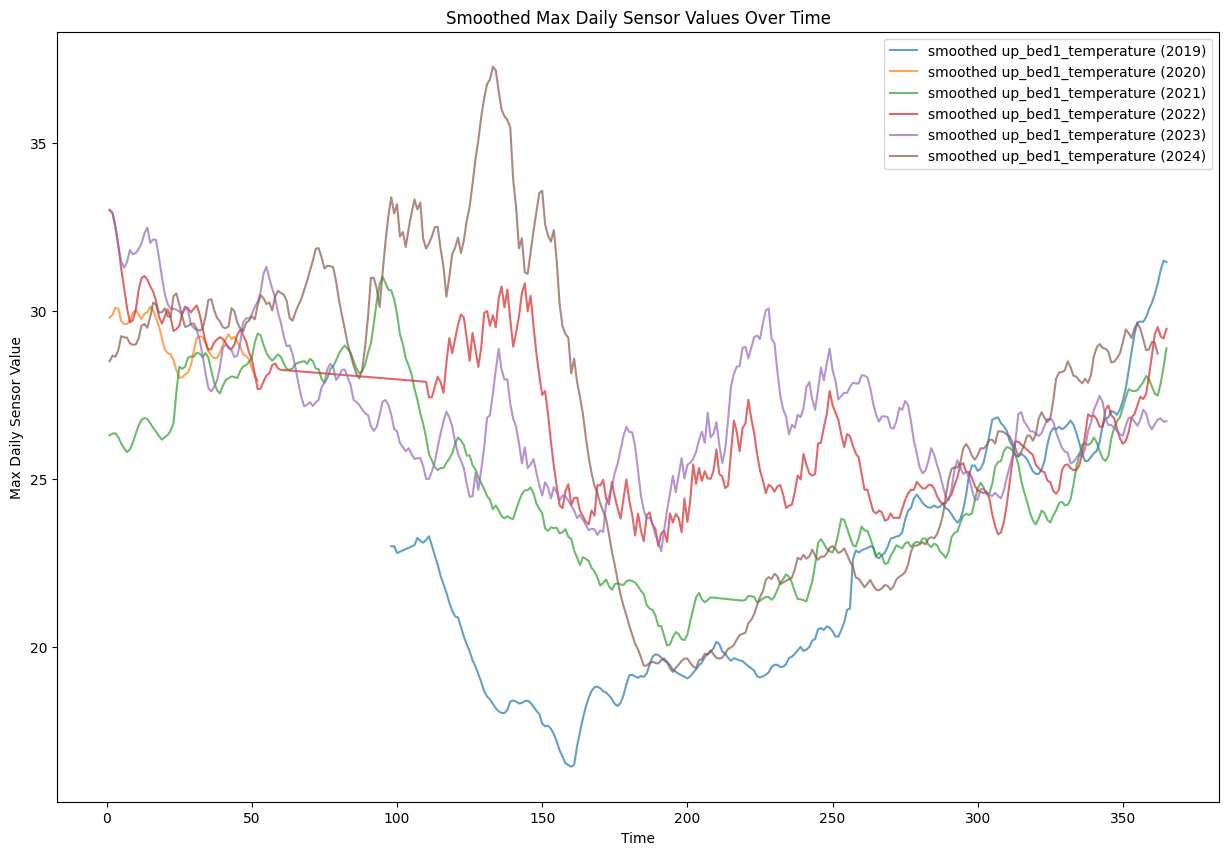

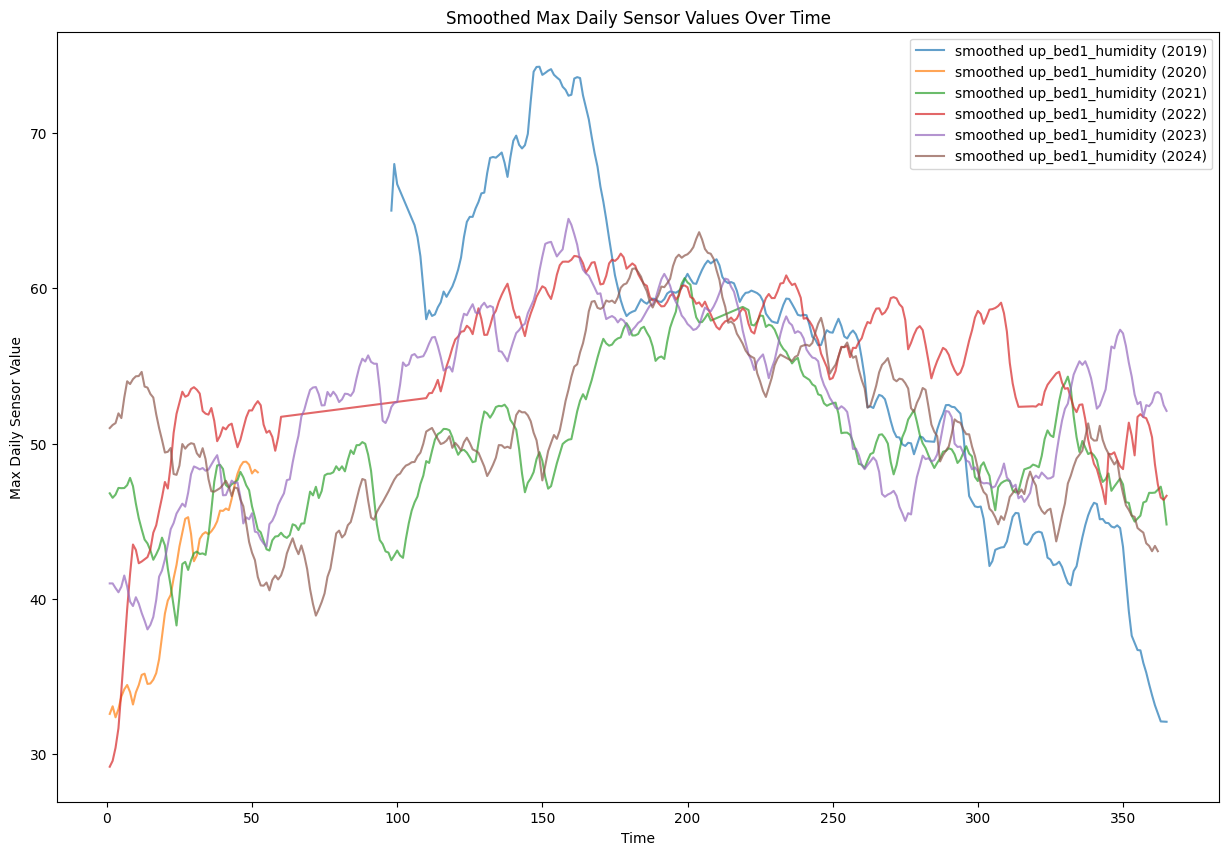

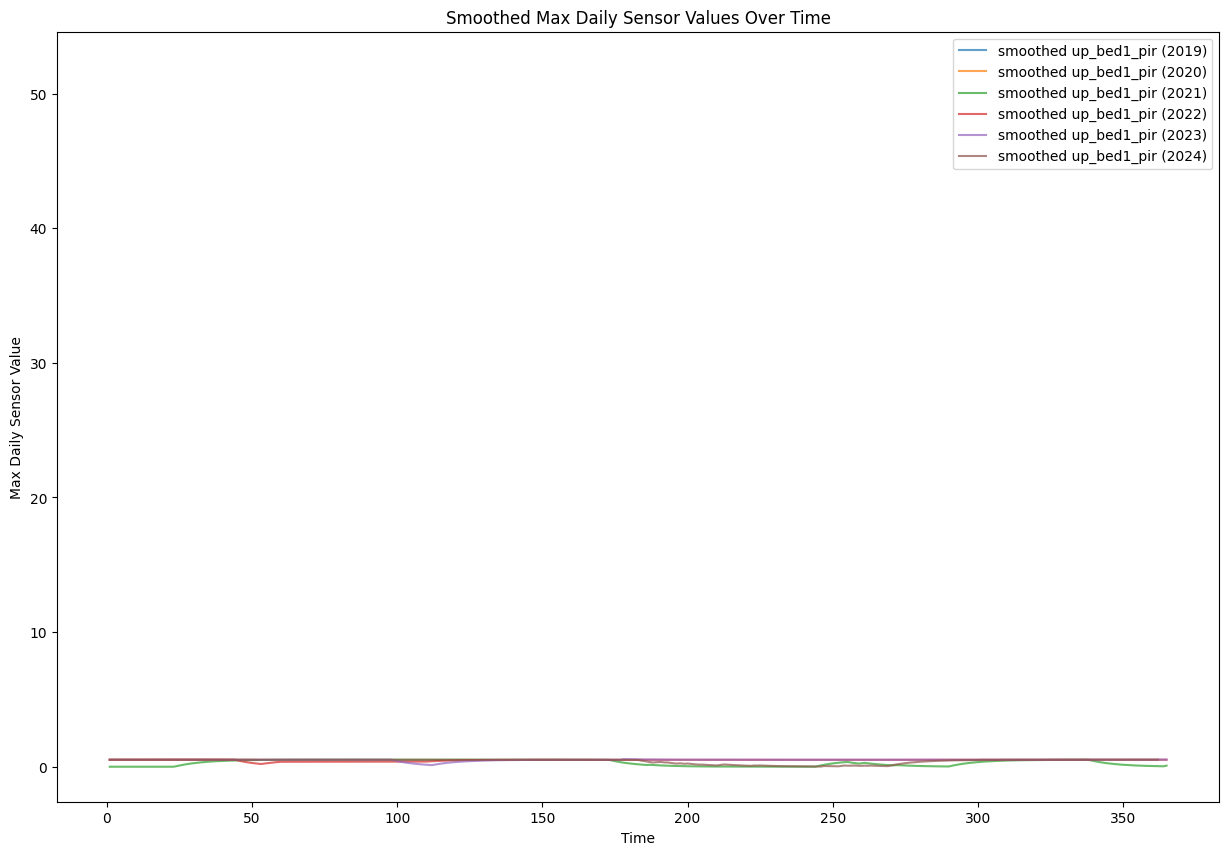

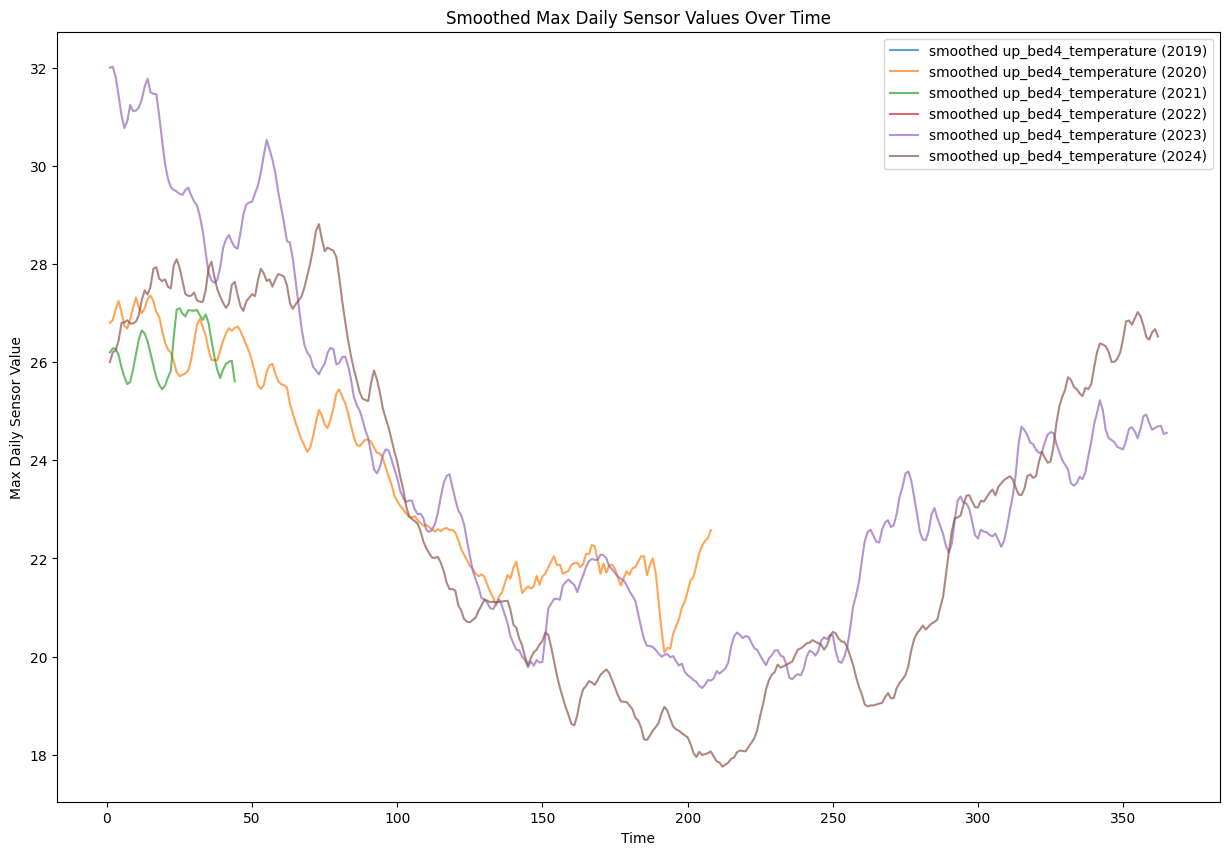

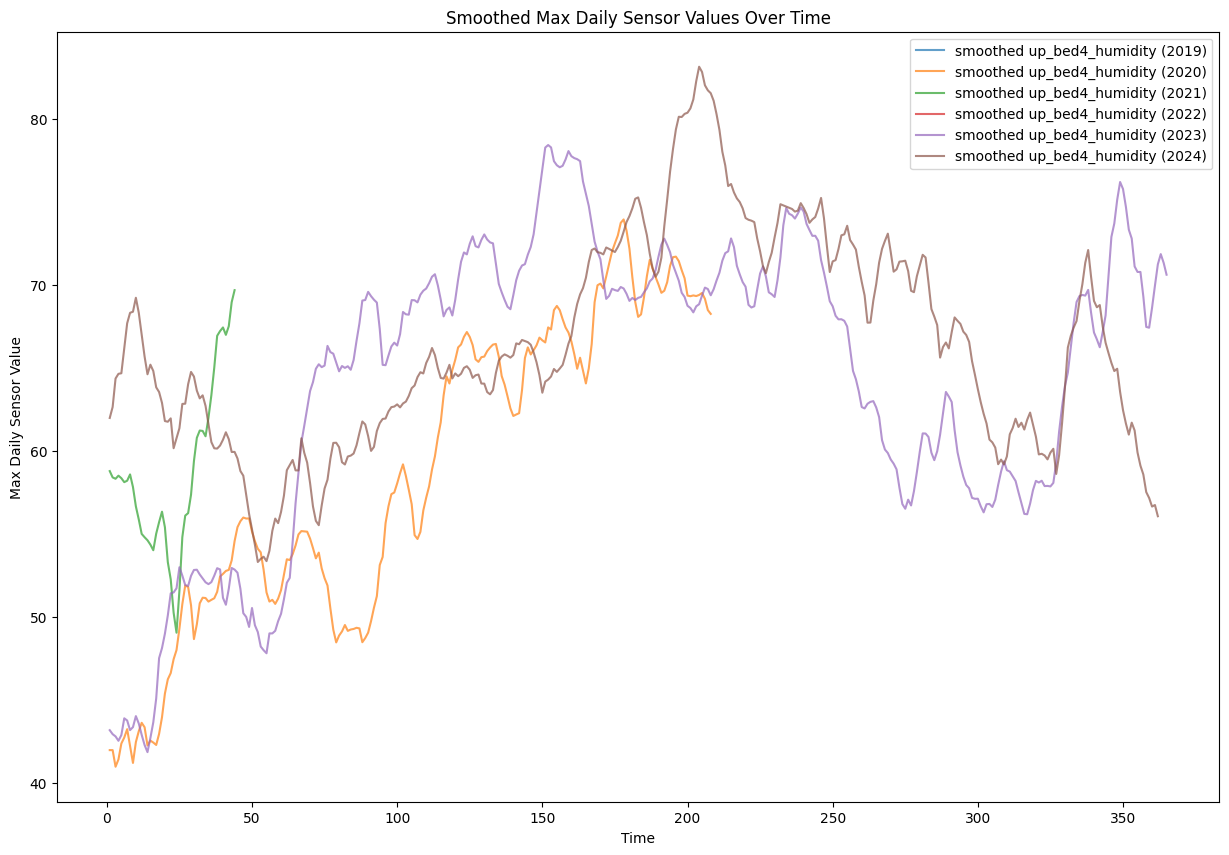

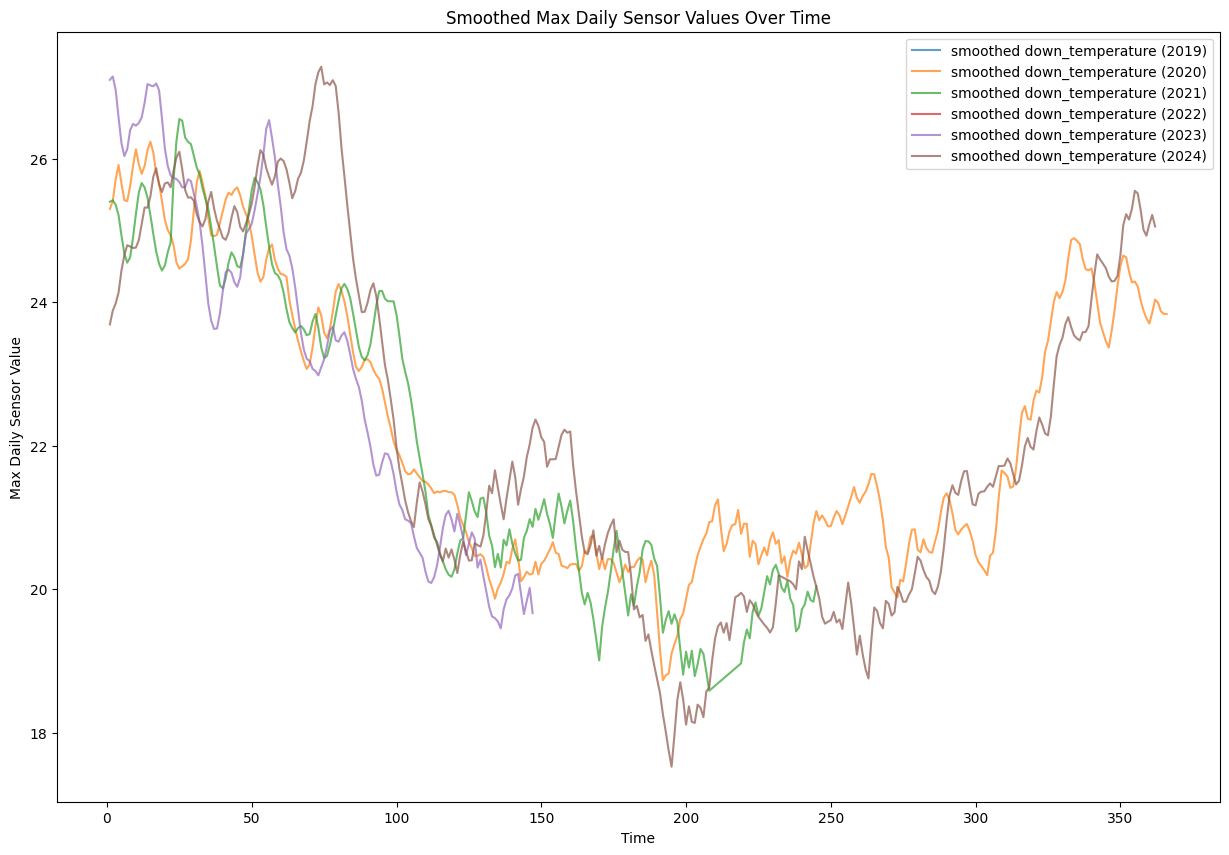

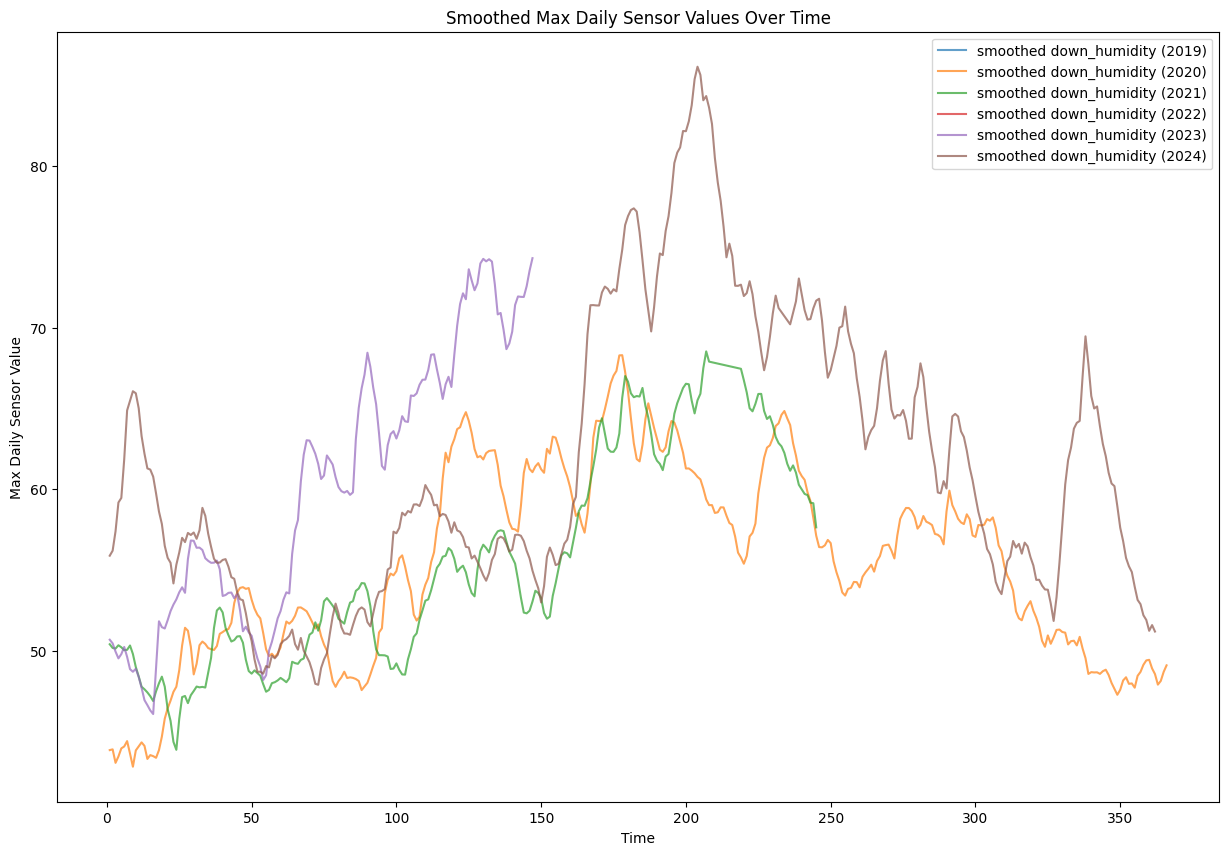

In [155]:
for sensor_name in sensor_names:
    #if ('up_bed1_temperature' in sensor_name):
    max_df = locals()[f'df_max_{sensor_name}']
    plt.figure(figsize=(15, 10))
    for year in years:
        year_data = max_df[max_df['year'] == year]
        year_values_ordered = year_data.sort_values(by=['day_of_year'], ascending=True)[sensor_name].to_list()
        year_values_smoothed = smooth(year_values_ordered, 0.9)
        #plt.plot(year_data['day_of_year'], year_values_ordered, label=f"{sensor_name} ({year})", alpha=0.7)
        plt.plot(year_data['day_of_year'], year_values_smoothed, label=f"smoothed {sensor_name} ({year})", alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Max Daily Sensor Value')
    plt.title('Smoothed Max Daily Sensor Values Over Time')
    plt.legend()
    plt.show()

# MIN DAILY VALUES

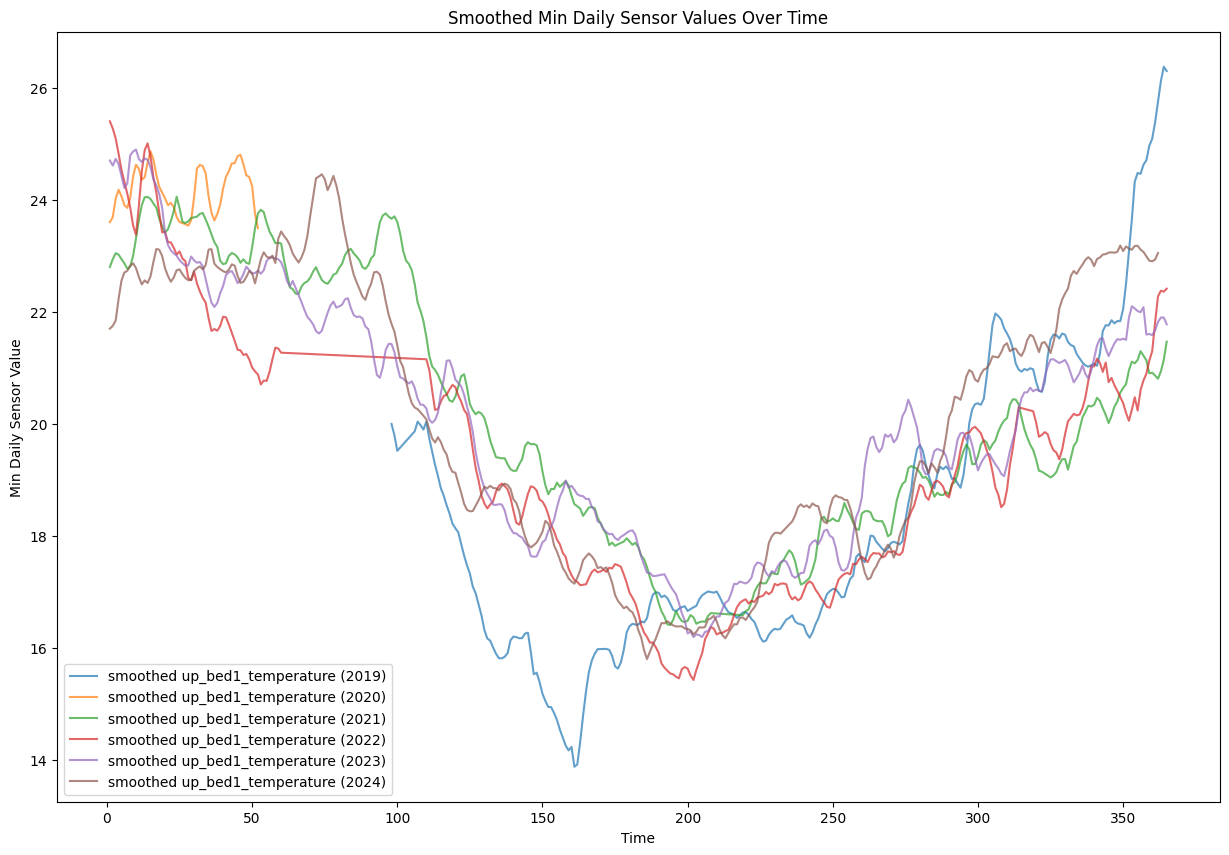

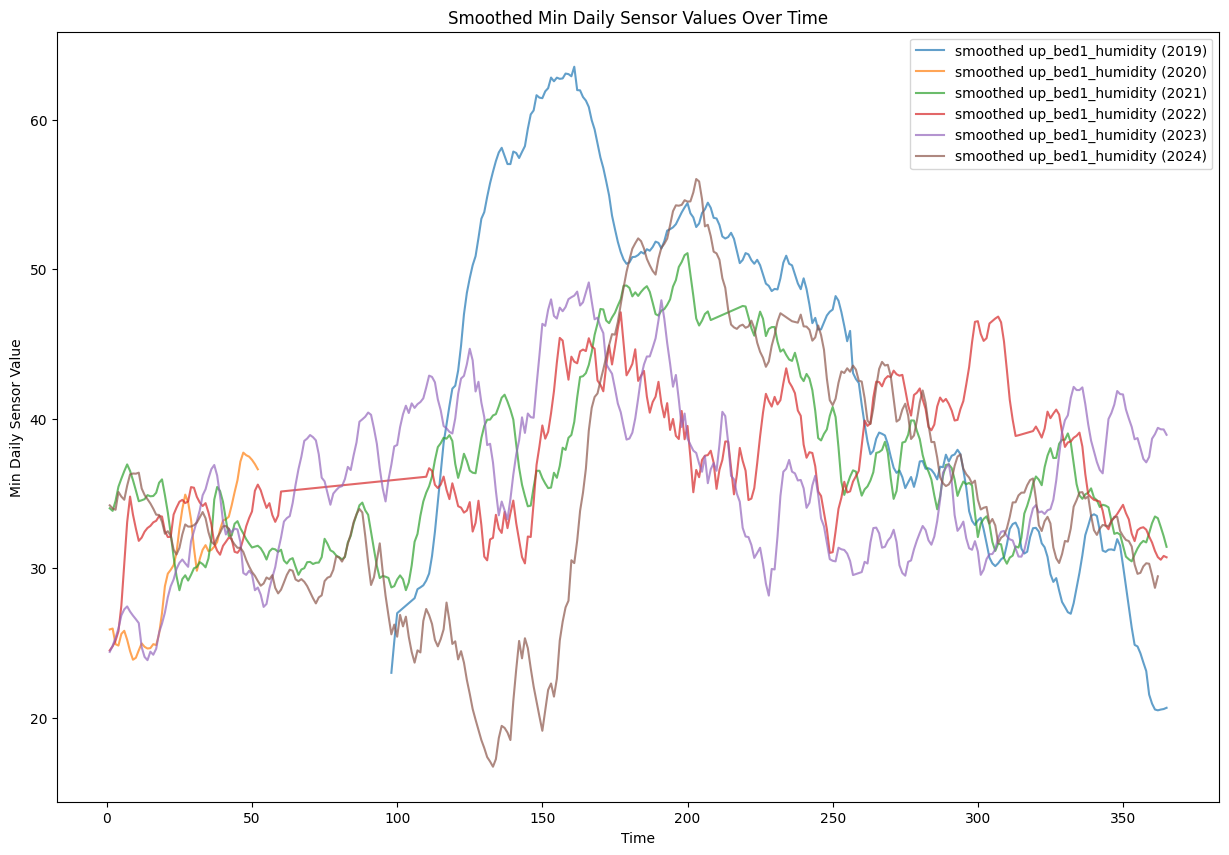

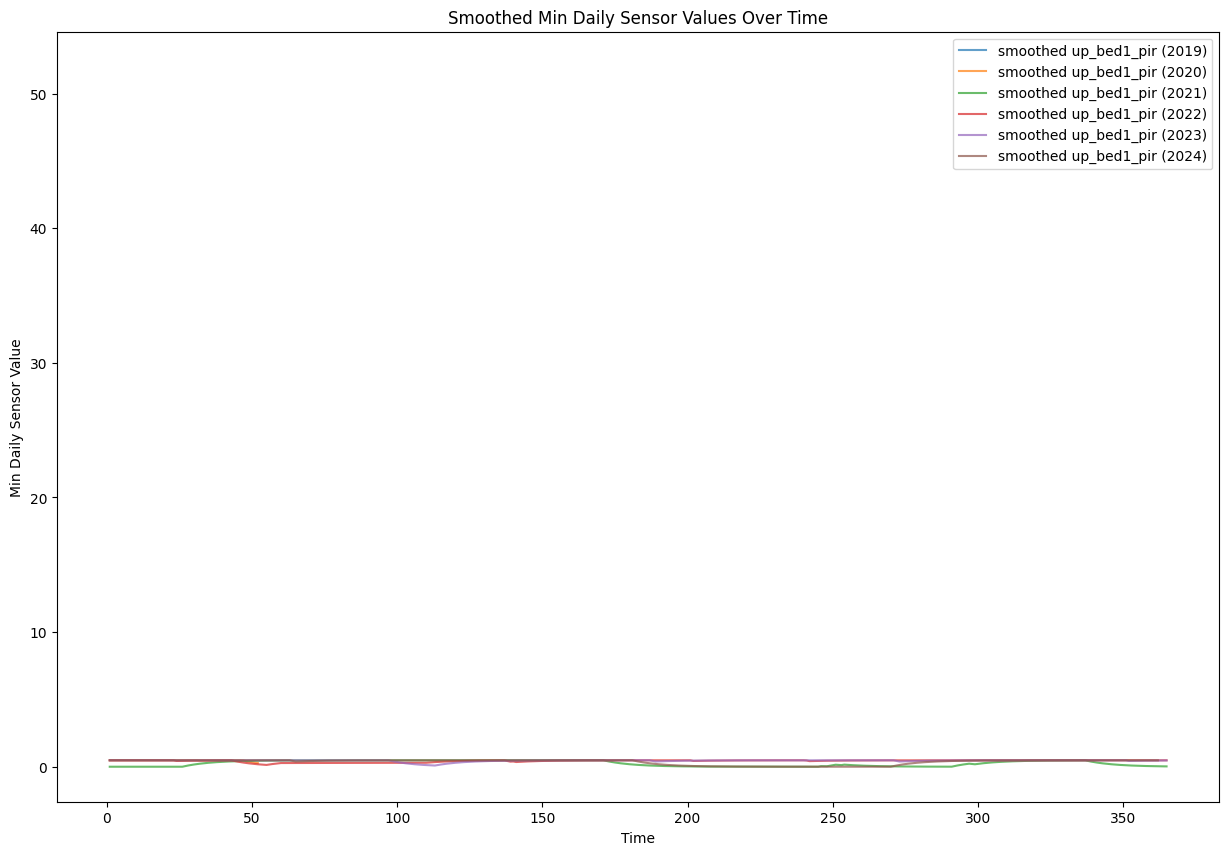

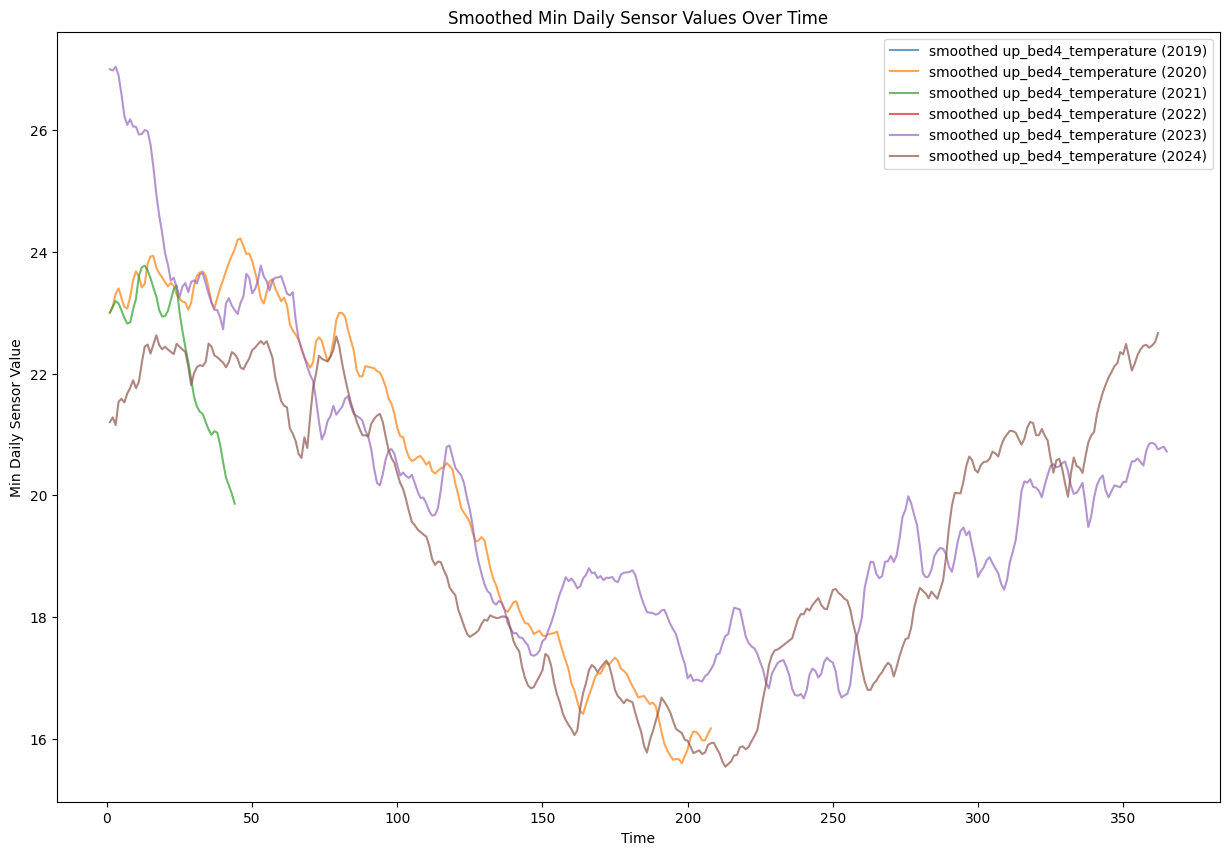

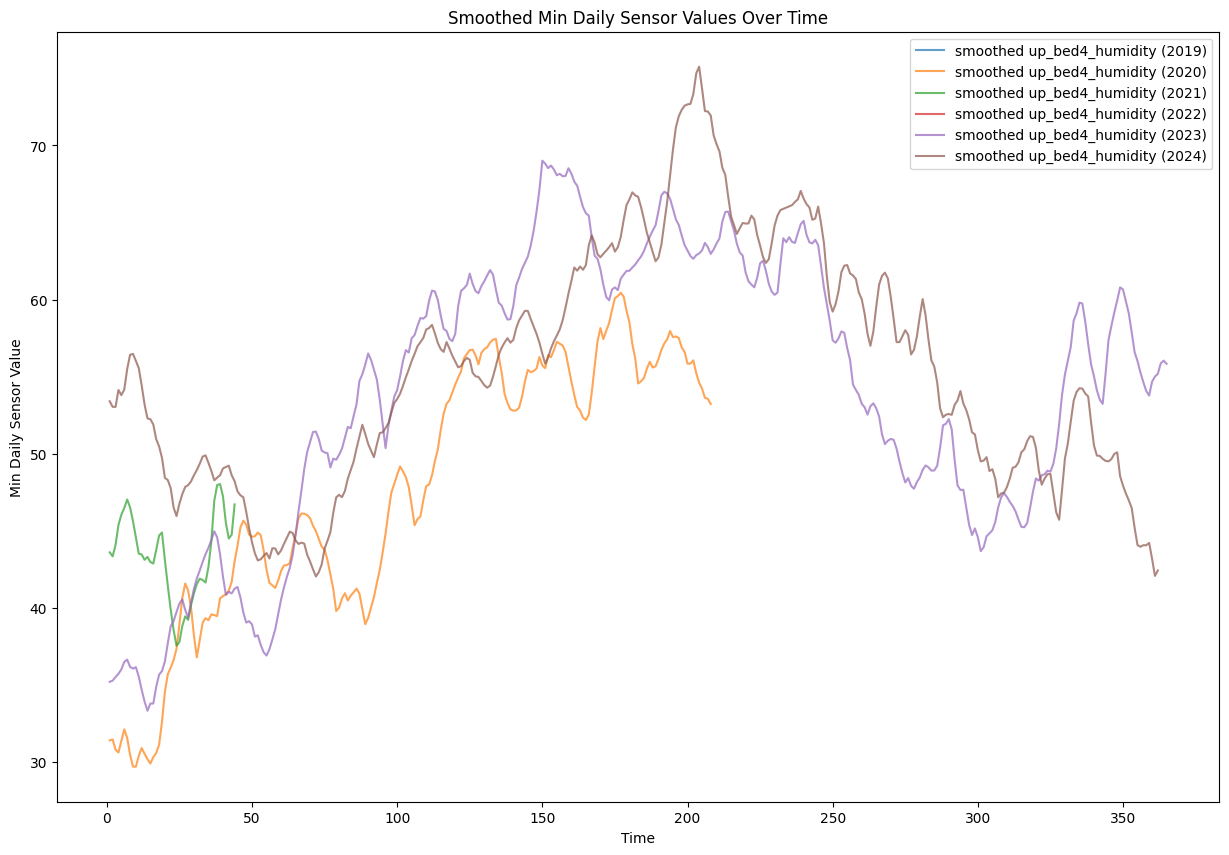

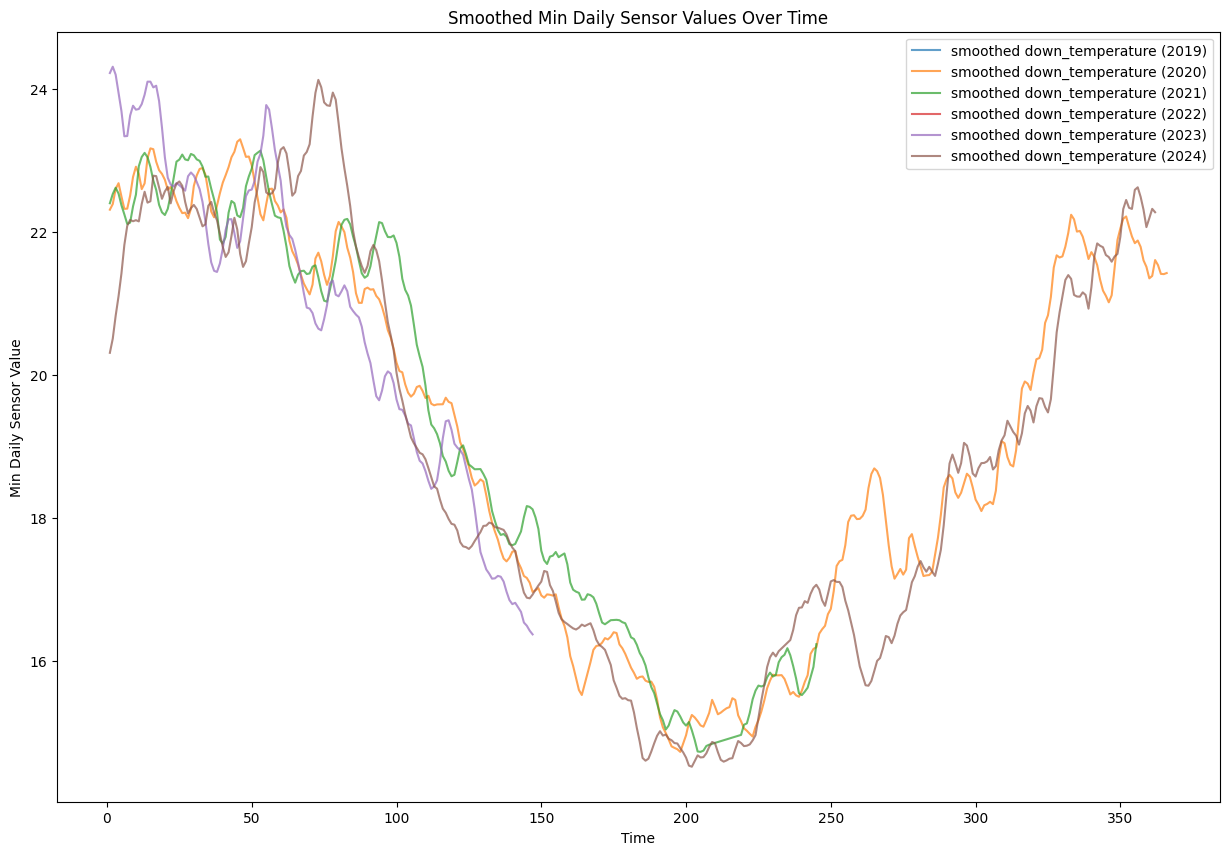

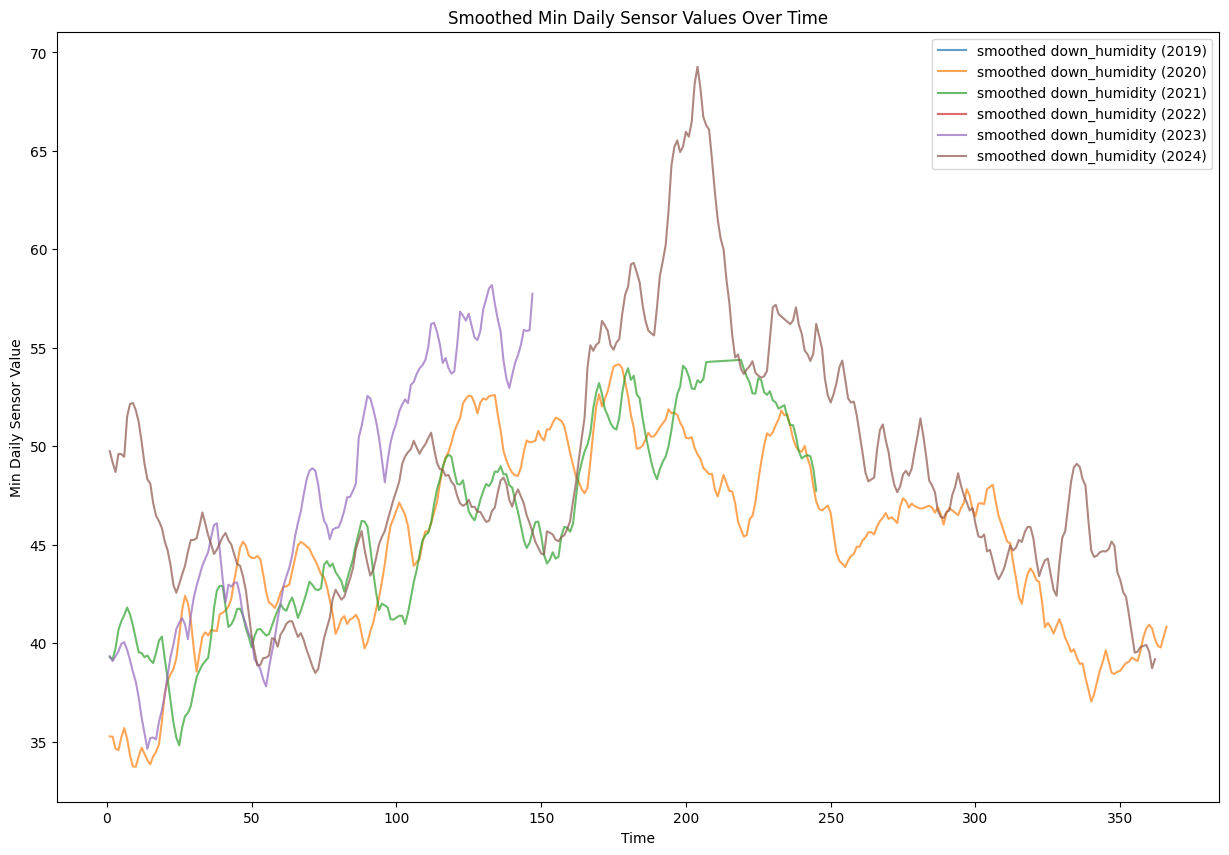

In [156]:
for sensor_name in sensor_names:
    #if ('up_bed1_temperature' in sensor_name):
    min_df = locals()[f'df_min_{sensor_name}']
    plt.figure(figsize=(15, 10))
    for year in years:
        year_data = min_df[min_df['year'] == year]
        year_values_ordered = year_data.sort_values(by=['day_of_year'], ascending=True)[sensor_name].to_list()
        year_values_smoothed = smooth(year_values_ordered, 0.9)
        #plt.plot(year_data['day_of_year'], year_values_ordered, label=f"{sensor_name} ({year})", alpha=0.7)
        plt.plot(year_data['day_of_year'], year_values_smoothed, label=f"smoothed {sensor_name} ({year})", alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Min Daily Sensor Value')
    plt.title('Smoothed Min Daily Sensor Values Over Time')
    plt.legend()
    plt.show()

# CALCULATIONS TODO

- is there a particular time of day temperature is important?  Compare temp at that time on a daily basis?
- can we spot times when upstairs changed?  e.g. date of blinds installed.  Date of double glazing? e.g. do two weeks either side of installation
- should we be measuring distance from optimal temperature of 23 degrees?
- validate a couple of days by hand calculations.

Parameters used to analyze collected data.

(DO THIS) Daily Discomfort Degree Hours (DDDH) ∑(20 − Ti) (◦Ch)
To quantify the level of discomfort experienced by individuals due to temperature variations throughout a day respect to the minimum comfort temperature assumed as 20 ◦C

(DONE) Average daily indoor outdoor temperature difference (Ti − To) (◦C) To reflect the gap between the indoor condition and the outdoor one

(DONE) Cumulative daily envelope performance ∑(Ti − To) (◦Ch)
To reflect the daily envelope performance on indoor temperature in a cumulative way.

(DONE Cumulative average daily indoor- outdoor temperature difference ∑(Ti − To) (◦Ch)
To reflect the cumulative value of the difference between indoor and outdoor temperatures in a day

(NO) Units of consumption UC To quantify the radiators' usage during the selected period by reading meters mounted on them
(NO) Average room temperature of the monitoring period Tr (◦C) The average between the indoor temperature and driving temperature in each room
(NO) Average daily driving temperature Td (◦C) To reflect the average daily driving temperature that is affected by its surrounding and subsequently affect the (Ti)
(NO) Daily average envelope performance index Ti − 20 Td − To
To reflect the efficacy of the envelope performance by comparing the goal, having indoor temperature higher than standard temperature of comfort compared to  its effort, i.e., considering the difference between driving temperature and outdoor temperature


- Could measure number of hours inside the 'comfort range' of 21 to 25 degrees celsius?  Hopefully after insulation, more hours are comfortable than previously.
- What is the preferred temperature/humidity levels for housing?
- can we show a similar graph to Fig7, i.e. for a single day show the rise and fall of temperature, then show after renovations how it rises and falls (both days should have similar outside temp graphs).


Confounding factors:
 - heating and cooling
 - opening/closing windows
 - opening/closing blinds

# BOM Temperatures

In [217]:
# Read the outside temperature CSV files into a DataFrame
# Climate data downloaded from http://www.bom.gov.au/climate/data/
# only has max and min temp per day.  The observations dataset also includes temps at 9am and 3pm.
for year in years:
    file_path = f"data/adelaide_max_temp/IDCJAC0010_023000_{year}_Data.csv"
    with open(file_path, 'rt') as f:
        #df = pd.read_csv(f, header=0, nrows=10000)
        outside_df = pd.read_csv(f, header=0)
        print(f"Year={year}")
        #print(outside_df['Day'].describe())
        locals()[f'outside_{year}_df'] = outside_df

print(outside_2024_df.head(4))

Year=2019
Year=2020
Year=2021
Year=2022
Year=2023
Year=2024
  Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0010                                 23000  2024      1    1   
1   IDCJAC0010                                 23000  2024      1    2   
2   IDCJAC0010                                 23000  2024      1    3   
3   IDCJAC0010                                 23000  2024      1    4   

   Maximum temperature (Degree C)  \
0                            27.9   
1                            28.9   
2                            27.0   
3                            32.8   

   Days of accumulation of maximum temperature Quality  
0                                            1       Y  
1                                            1       Y  
2                                            1       Y  
3                                            1       Y  


# Open Meteo Hourly Temperatures

In [158]:
#openmateo allows you to download hourly temperatures (and other climate data) since 1940 for any location on earth.  I set the location to my house, and downloaded a dataset for each year of interest.
#hourly data allows us to graph the outside temperature vs inside temp.
for year in years:
#for year in [2023, 2024]:
    file_path = f"data/open-meteo-adelaide-{year}.csv"
    with open(file_path, 'rt') as f:
        #df = pd.read_csv(f, header=0, nrows=10000)
        openmeteo_outside_df = pd.read_csv(f, header=2)
        #print(openmeteo_outside_df.head(4))
        print(f"Year={year}")
        #print(openmeteo_outside_df['temperature_2m'].describe())
        # Convert from GMT to local timezone
        openmeteo_outside_df['time'] = pd.to_datetime(openmeteo_outside_df['time']).dt.tz_localize('GMT')
        openmeteo_outside_df['timelocal'] = pd.to_datetime(openmeteo_outside_df['time']).dt.tz_convert('Australia/Adelaide')
        openmeteo_outside_df['year'] = pd.DatetimeIndex(openmeteo_outside_df['timelocal']).year
        openmeteo_outside_df['month'] = pd.DatetimeIndex(openmeteo_outside_df['timelocal']).month
        openmeteo_outside_df['day'] = pd.DatetimeIndex(openmeteo_outside_df['timelocal']).day
        openmeteo_outside_df['hour'] = pd.DatetimeIndex(openmeteo_outside_df['timelocal']).hour
        openmeteo_outside_df['day_of_year'] = openmeteo_outside_df['timelocal'].dt.dayofyear
        openmeteo_outside_df['time_of_day'] = openmeteo_outside_df['timelocal'].apply(lambda x: x.replace(year=1990, month=1, day=1)) #.dt.time
        locals()[f'openmeteo_outside_{year}_df'] = openmeteo_outside_df

print(openmeteo_outside_2024_df.head(4))

Year=2019
Year=2020
Year=2021
Year=2022
Year=2023
Year=2024
                       time  temperature_2m                 timelocal  year  \
0 2024-01-01 00:00:00+00:00            25.3 2024-01-01 10:30:00+10:30  2024   
1 2024-01-01 01:00:00+00:00            27.4 2024-01-01 11:30:00+10:30  2024   
2 2024-01-01 02:00:00+00:00            27.5 2024-01-01 12:30:00+10:30  2024   
3 2024-01-01 03:00:00+00:00            28.0 2024-01-01 13:30:00+10:30  2024   

   month  day  hour  day_of_year               time_of_day  
0      1    1    10            1 1990-01-01 10:30:00+10:30  
1      1    1    11            1 1990-01-01 11:30:00+10:30  
2      1    1    12            1 1990-01-01 12:30:00+10:30  
3      1    1    13            1 1990-01-01 13:30:00+10:30  


# TEMPERATURE DIFFERENCE INSIDE VS OUTSIDE

Outside max temperature dataframes have the correct number of entries for each year.
Now calculate:
 - Average daily indoor outdoor max temperature difference (Ti − To) (◦C) 

Year=2022, sensor=up_bed1_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 5.4075466200464755
Year=2023, sensor=up_bed1_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 4.495147062915702
Year=2024, sensor=up_bed1_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 3.641163026917039


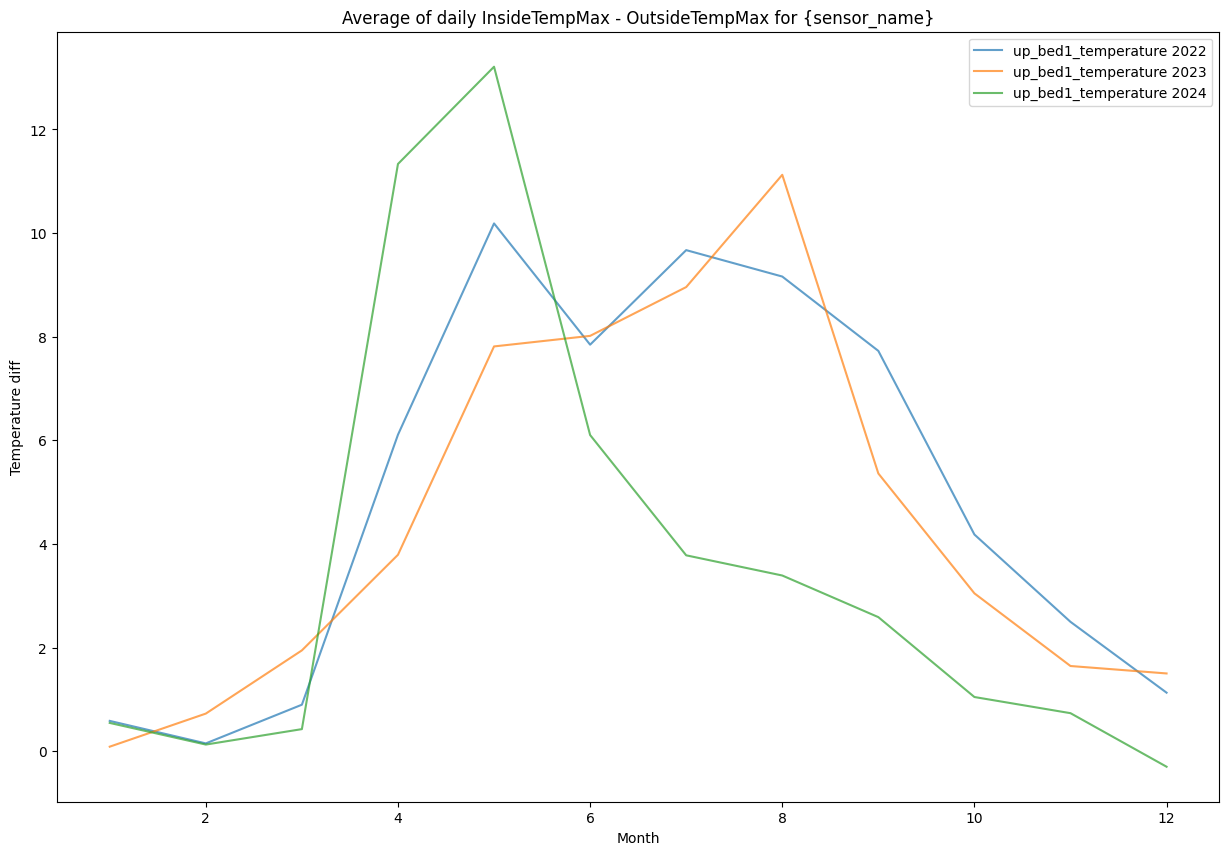

Year=2022, sensor=up_bed4_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 2.7163802978233678
Year=2023, sensor=up_bed4_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 1.173553719008264
Year=2024, sensor=up_bed4_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = -0.609590316573464


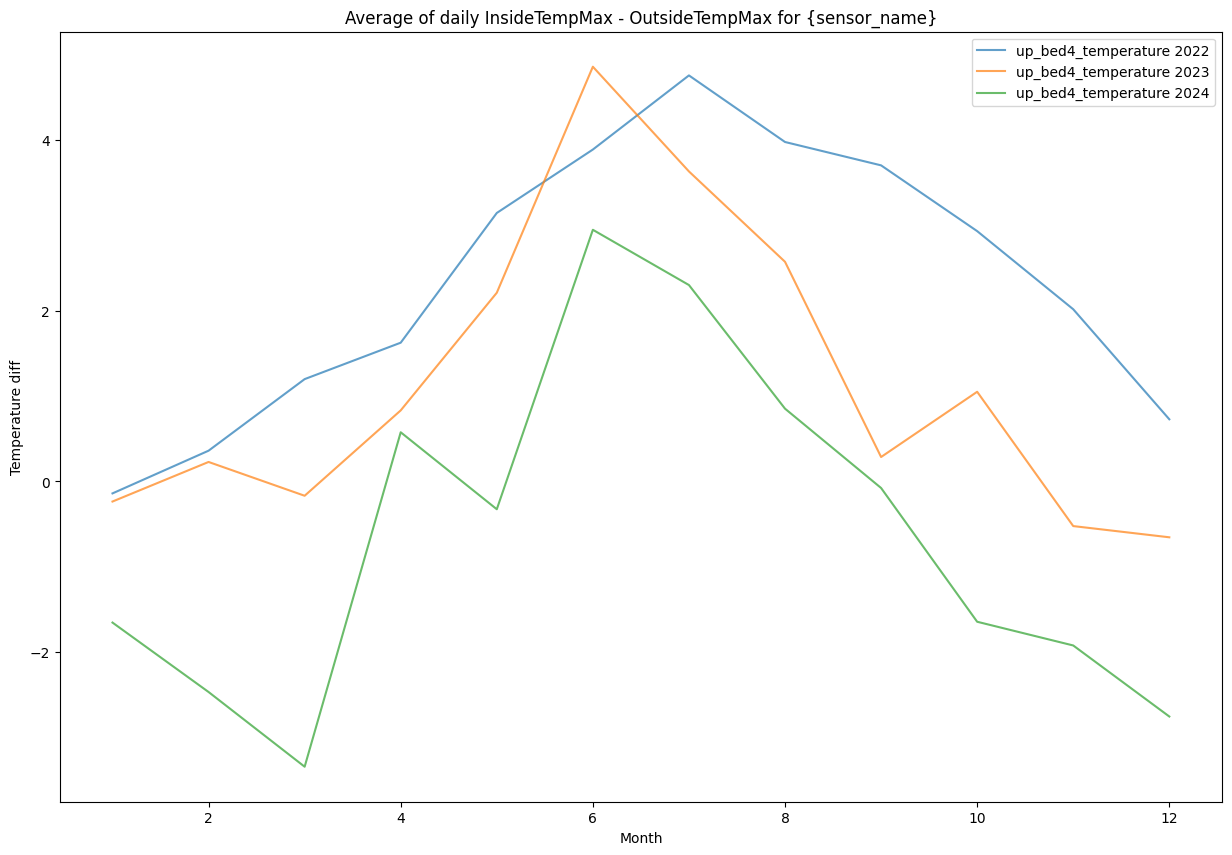

Year=2022, sensor=down_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = 0.10581123737361094
Year=2023, sensor=down_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = -0.7040582621798344
Year=2024, sensor=down_temperature, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = -1.261630269172067


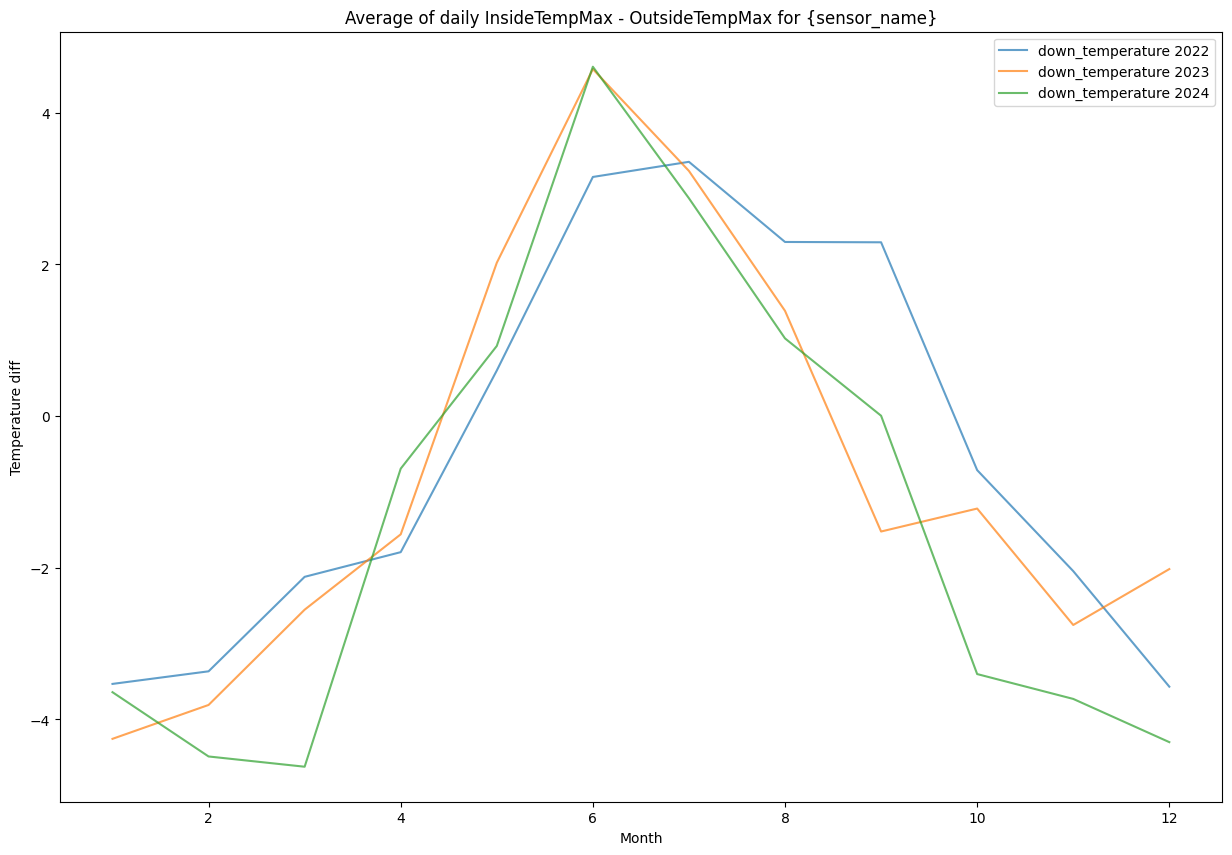

In [159]:
for sensor_name in ['up_bed1_temperature','up_bed4_temperature','down_temperature']:
    #for year in years:
    plt.figure(figsize=(15, 10))
    for year in [2022,2023,2024]:
        # Max indoor temp
        indoor_all_df = locals()[f'df_max_{sensor_name}']
        #print(indoor_all_df.describe())
        indoor_data = indoor_all_df[indoor_all_df['year'] == year]
        #.replace(to_replace=np.nan, value=-99)
        indoor_data_ordered = indoor_data.sort_values(by=['day_of_year'], ascending=True)
        #print(indoor_data_ordered.describe())
        # Max outdoor temp
        outdoor_df = locals()[f'outside_{year}_df']
        outdoor_data_ordered = outdoor_df.sort_values(by=['Month','Day'], ascending=True)
        outdoor_data_ordered['day_of_year'] = range(1,len(outdoor_data_ordered)+1)  # add the "day_of_year" column
        # The indoor and outdoor dataframes may be of different lengths.  Merge them based on the day_of_year field
        merged = outdoor_data_ordered.merge(indoor_data_ordered, how='left', on='day_of_year')
        #print(merged.describe())
        
        diff_of_max = merged[sensor_name] - merged['Maximum temperature (Degree C)']
        #print(diff_of_max)
        # Calculate average of the diff
        #avg_diff_of_max = diff_of_max.abs().mean()  # SHOULD IT BE THE ABSOLUTE DIFF?
        avg_diff_of_max = diff_of_max.mean()
        print(f"Year={year}, sensor={sensor_name}, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = {avg_diff_of_max}")

        monthly_diff = pd.DataFrame(columns=['Month','temp_diff'])
        for month in range(1, 13):
            #print(f"month={month}")
            #print(merged.head(4))
            month_merged = merged.query(f'Month=={month}')
            diff_of_max = month_merged[sensor_name] - month_merged['Maximum temperature (Degree C)']
            #avg_diff_of_max = diff_of_max.abs().mean()  # SHOULD IT BE THE ABSOLUTE DIFF?
            avg_diff_of_max = diff_of_max.mean()
            #print(f"Month={month}, average of absolute daily MaxIndoorTemp - MaxOutdoorTemp = {avg_diff_of_max}")
            monthly_diff.at[month-1, 'Month'] = month
            monthly_diff.at[month-1, 'temp_diff'] = avg_diff_of_max
        plt.plot(monthly_diff['Month'], monthly_diff['temp_diff'], label=f"{sensor_name} {year}", alpha=0.7)
    plt.xlabel('Month')
    plt.ylabel('Temperature diff')
    plt.title('Average of daily InsideTempMax - OutsideTempMax for {sensor_name}')
    plt.legend()
    plt.show()
            
        

The average daily indoor outdoor max temperature difference shows a step change from 2021 to 2022.  Is that when we made changes to the house, or just due to moving the sensors.  I think it was when I moved the the sensors to their current location from bed1 and bed4.  Downstairs stayed in same location.

For bed1 and bed4 the yearly trend is down, i.e. outside and inside max temps are closer.  That doesn't make sense.  But as we saw earlier, the max temps per day are not predictable, and probably depend a lot on when the airconditioner was running.

<b>In terms of max daily temperatures:</b>
The monthly calculations show that during summer, bed1 max temp is similar to outside, while in winter it is 8 to 10 degrees warmer than outside.
In contrast, in summer bed4 is 2 degrees cooler than outside, and in winter 4 to 5 degrees warmer than outside.
Downstairs in summer is 4 degrees cooler than outside, and in winter 4 degrees warmer than outside.

# CUMULATIVE HOURLY TEMP DIFFERENCE INSIDE VS OUTSIDE

Year=2023, sensor=up_bed1_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 59053.666577608965


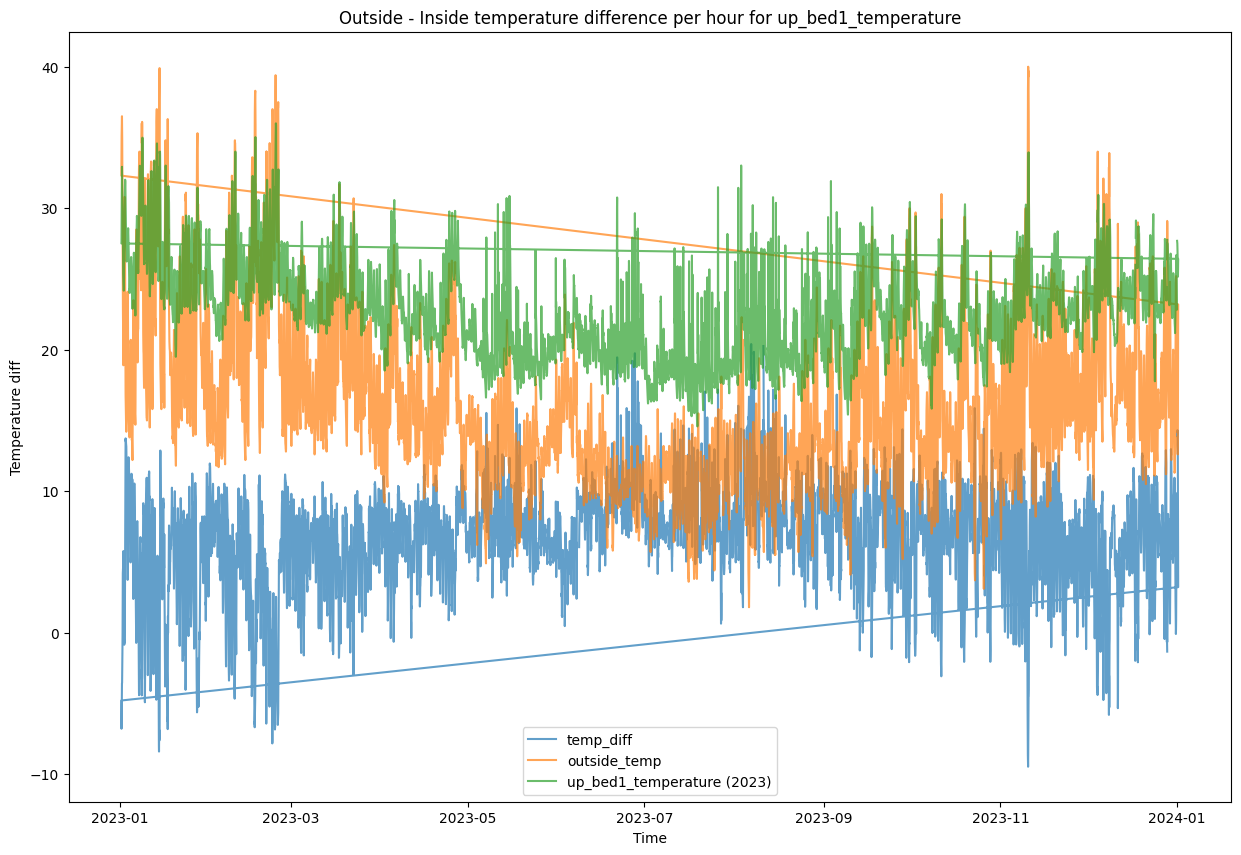

Year=2024, sensor=up_bed1_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 53699.53817529575


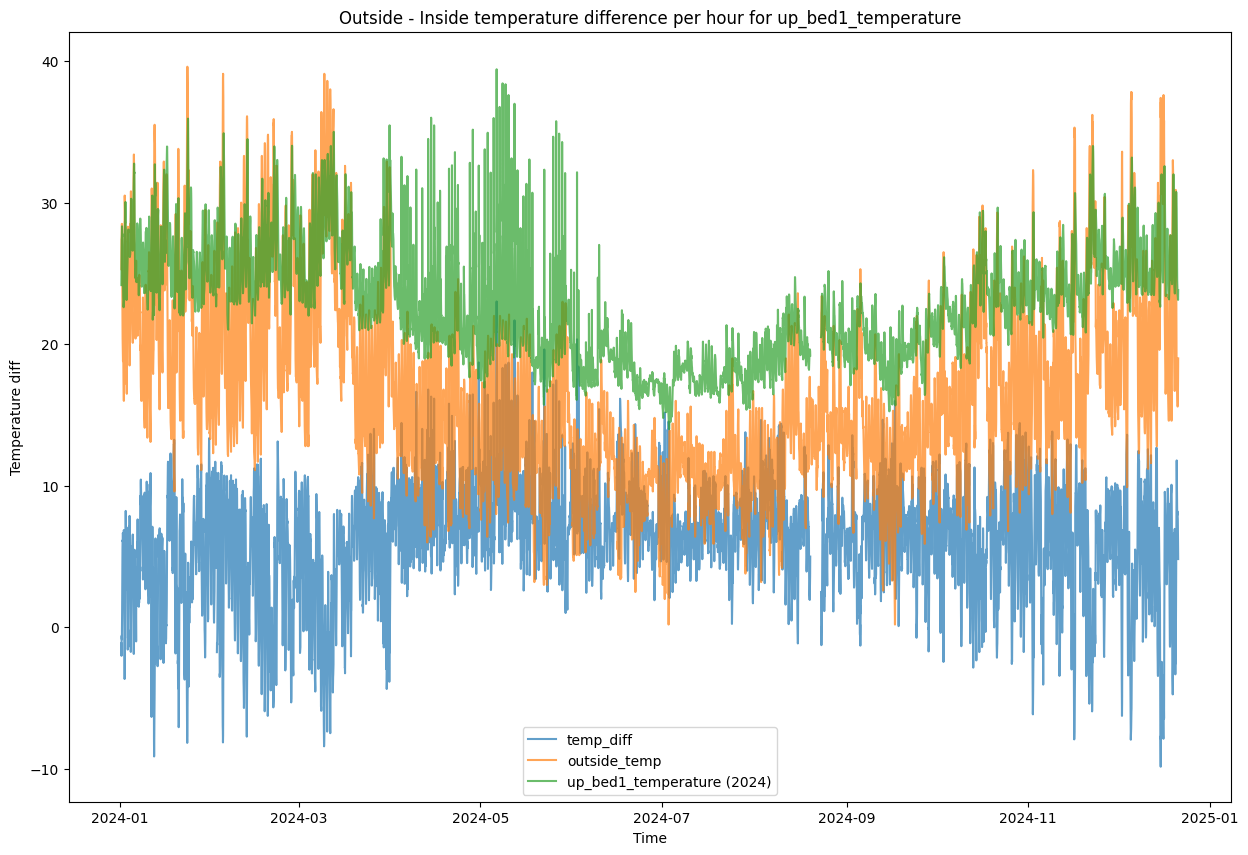

Year=2023, sensor=up_bed4_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 50161.52297498802


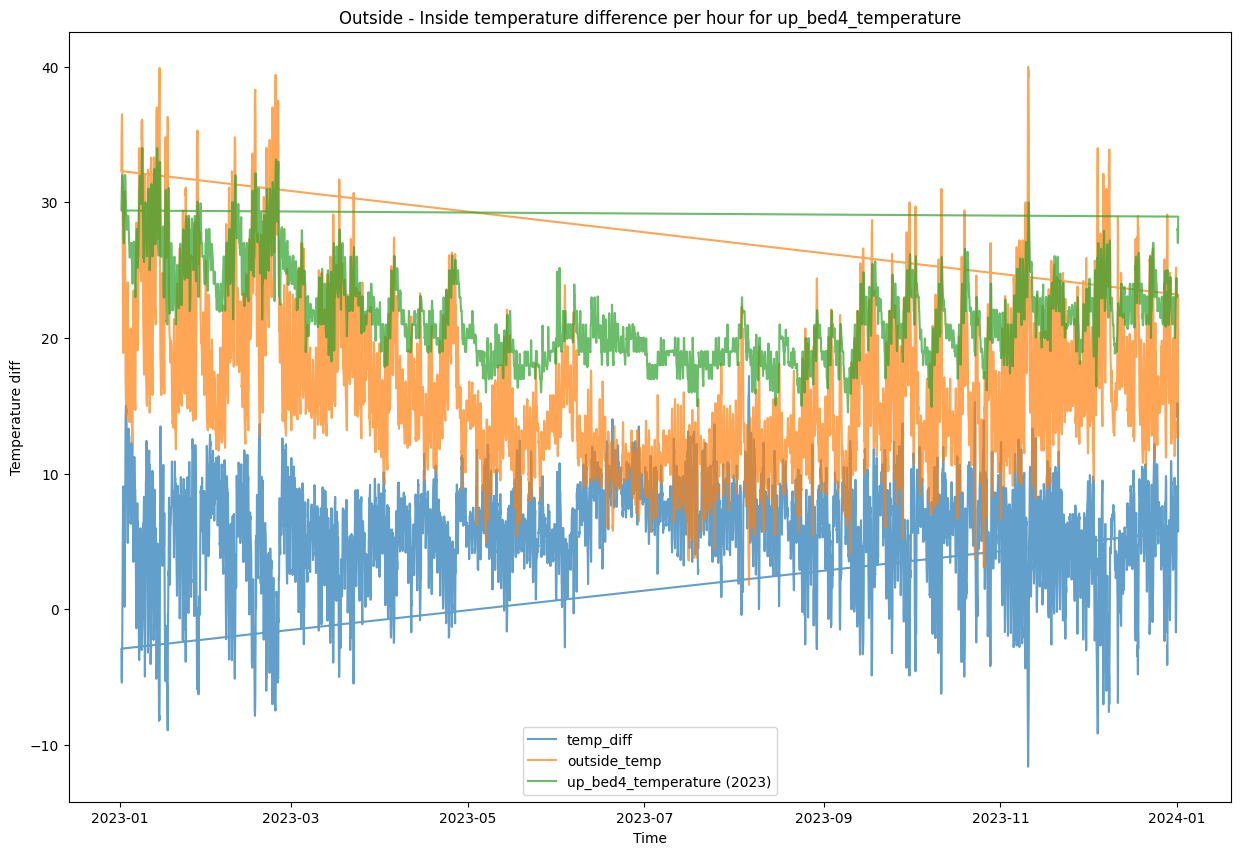

Year=2024, sensor=up_bed4_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 40190.664142616675


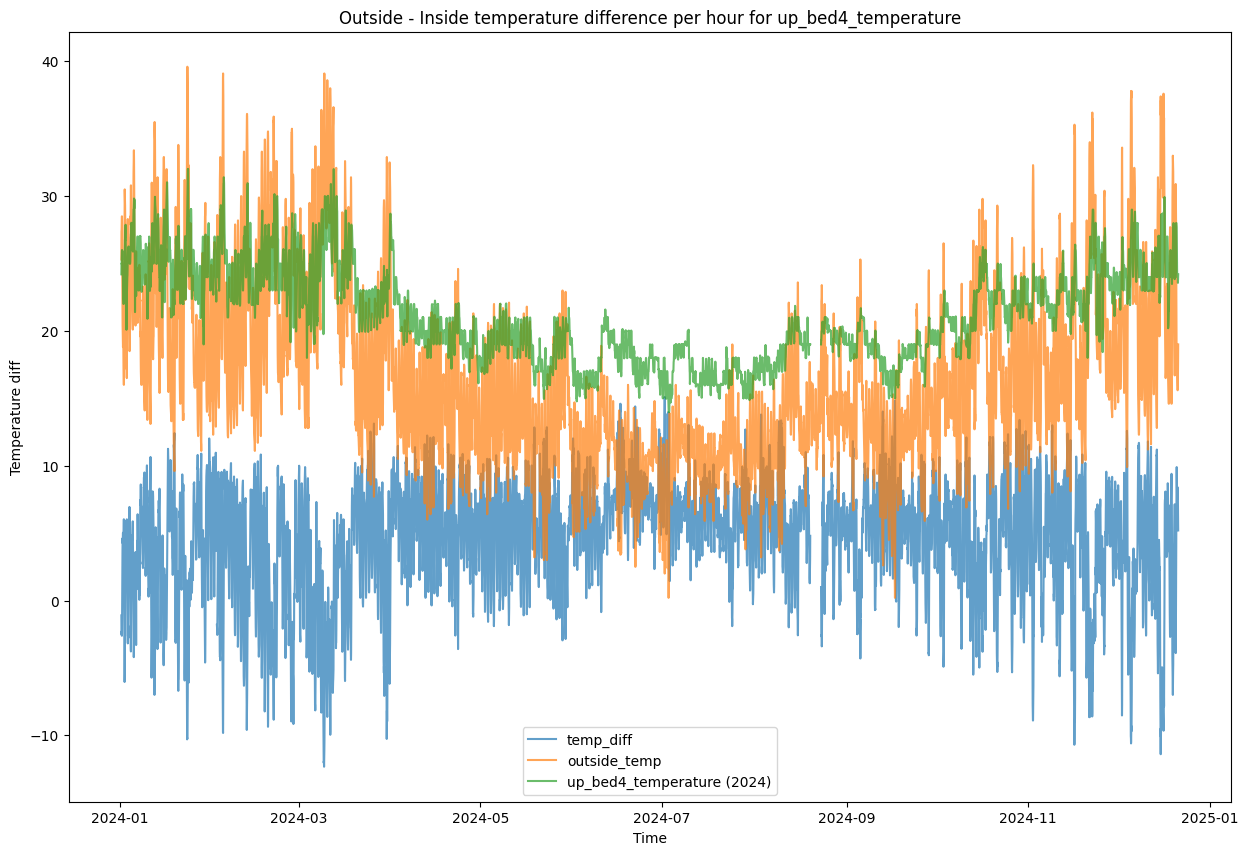

Year=2023, sensor=down_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 34586.261308091875


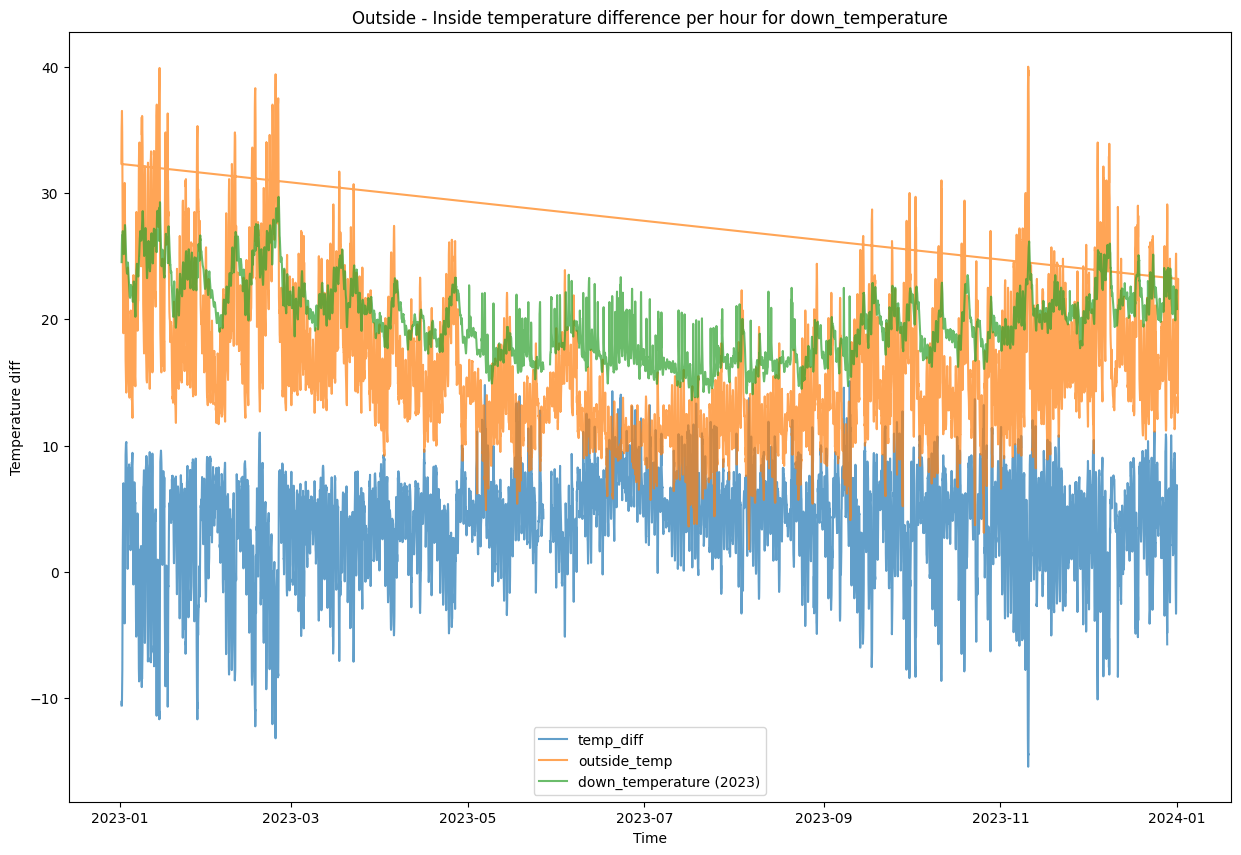

Year=2024, sensor=down_temperature, cumsum of hourly IndoorTemp - OutdoorTemp difference = 32307.27696364444


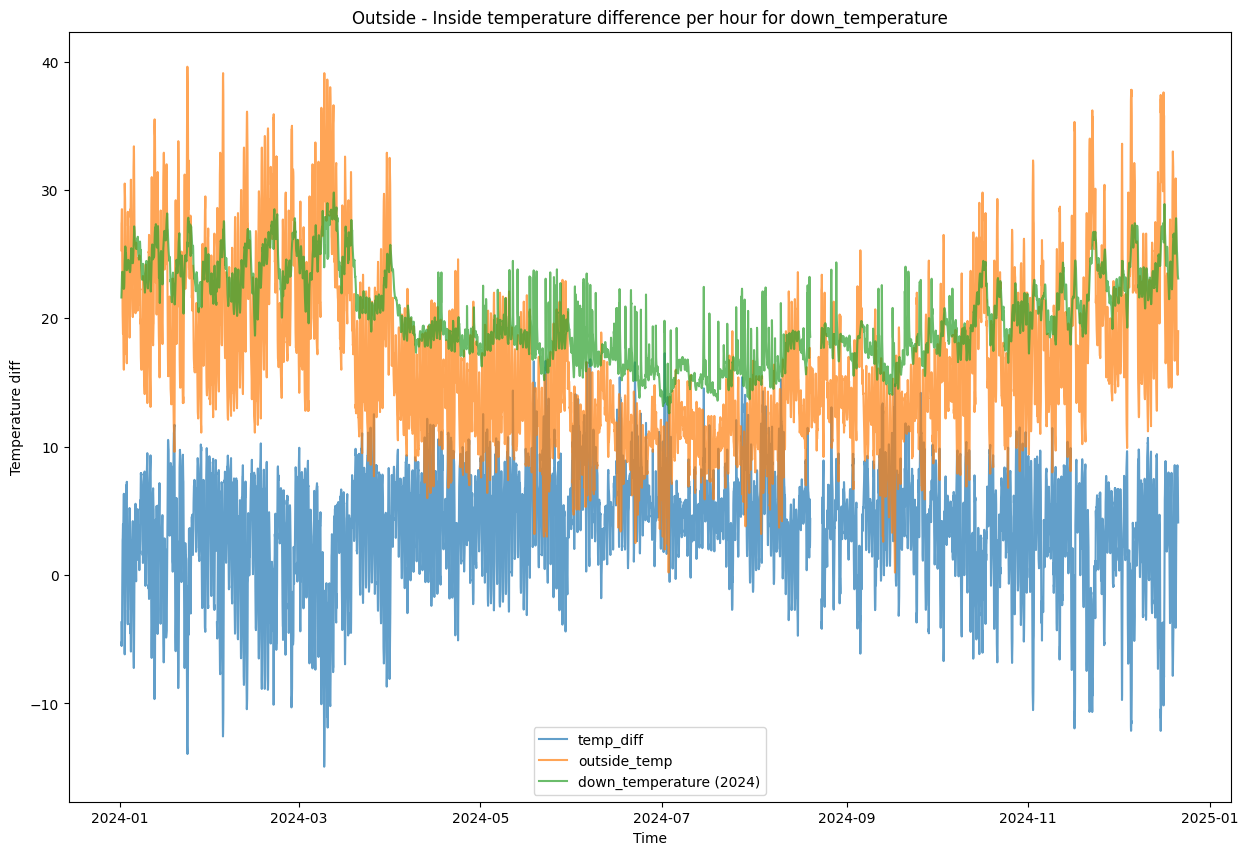

In [204]:
# Cumulative daily envelope performance ∑(Ti − To) (◦Ch) To reflect the daily envelope performance on indoor temperature in a cumulative way.
# compare hourly indoor vs outdoor temps
for sensor_name in ['up_bed1_temperature','up_bed4_temperature','down_temperature']:
#for sensor_name in ['up_bed1_temperature']:
    #for year in years:
    for year in [2023,2024]:
        plt.figure(figsize=(15, 10))
        # Get hourly indoor temps
        indoor_all_df = locals()[f'df_hourly_{sensor_name}']
        indoor_data = indoor_all_df[indoor_all_df['year'] == year]
        #.replace(to_replace=np.nan, value=-99)
        indoor_data_ordered = indoor_data.sort_values(by=['day_of_year','hour'], ascending=True)
        #print(indoor_data_ordered.head(14))
        # Max outdoor temp
        outdoor_df = locals()[f'openmeteo_outside_{year}_df']
        outdoor_data_ordered = outdoor_df.sort_values(by=['day_of_year','hour'], ascending=True)
        # The indoor and outdoor dataframes may be of different lengths.  Merge them based on their hourly timestamp
        merged = pd.merge(left=outdoor_data_ordered, right=indoor_data_ordered, how='left', left_on=['day_of_year','hour'], right_on=['day_of_year','hour'])
        #print(merged.describe())
        merged['temp_diff'] = merged[sensor_name] - merged['temperature_2m']

        #merged = merged.query('month_x == 9 & day_x == 22')
        #merged = merged.query('month_x == 11')
        #print(merged.head(4))
        # Calculate average of the diff
        cumulative_diff_of_hourly_temps = merged['temp_diff'].cumsum().iloc[-1]  # should use abs()?
        print(f"Year={year}, sensor={sensor_name}, cumsum of hourly IndoorTemp - OutdoorTemp difference = {cumulative_diff_of_hourly_temps}")

        # Plot the diff over time
        # create a subset of time
        
        plt.plot(merged['timelocal'], merged['temp_diff'], label="temp_diff", alpha=0.7)
        plt.plot(merged['timelocal'], merged['temperature_2m'], label="outside_temp", alpha=0.7)
        plt.plot(merged['timelocal'], merged[sensor_name], label=f"{sensor_name} ({year})", alpha=0.7)
        
        plt.xlabel('Time')
        plt.ylabel('Temperature diff')
        plt.title(f'Outside - Inside temperature difference per hour for {sensor_name}')
        plt.legend()
        plt.show()
        
        

Conclusions for graph of september
1) The indoor temp is around 20 degrees and outdoor a few degrees cooler, i.e. indoor stays warmer.
2) the indoor temperature variance is a lot less than outside.  i.e. indoor is more stable
3) the temperature difference shows inside is warmer during winter.
   
Conclusions for graph of 2024
1) the variance in indoor temps is greatly reduced in June when we got double glazing
Conclusions for graph of 22nd Sep 2024
2) upstairs sensor temp is very stable


TODO:
1) check numbers by hand
2) check why max indoor temperature in the hourly temps is less than the max temp using every reading.
3) look at same month in 2023.  Is variance any different?

# Single Day - Hot
for a single day show the rise and fall of temperature, then show after renovations how it rises and falls (both days should have similar outside temp graphs).

In [218]:
#find a hot day in 2024
outdoor_df = locals()[f'outside_2024_df']
outdoor_df['day_of_year'] = range(1,len(outdoor_df)+1)  # add the "day_of_year" column
hot_2024 = outdoor_df[outdoor_df['Maximum temperature (Degree C)'] > 40]
hot_2024

Product code  Bureau of Meteorology station number  Year  Month  Day  \
22    IDCJAC0010                                 23000  2024      1   23   
339   IDCJAC0010                                 23000  2024     12    5   

     Maximum temperature (Degree C)  \
22                             41.2   
339                            40.1   

     Days of accumulation of maximum temperature Quality  day_of_year  
22                                             1       Y           23  
339                                            1       N          340

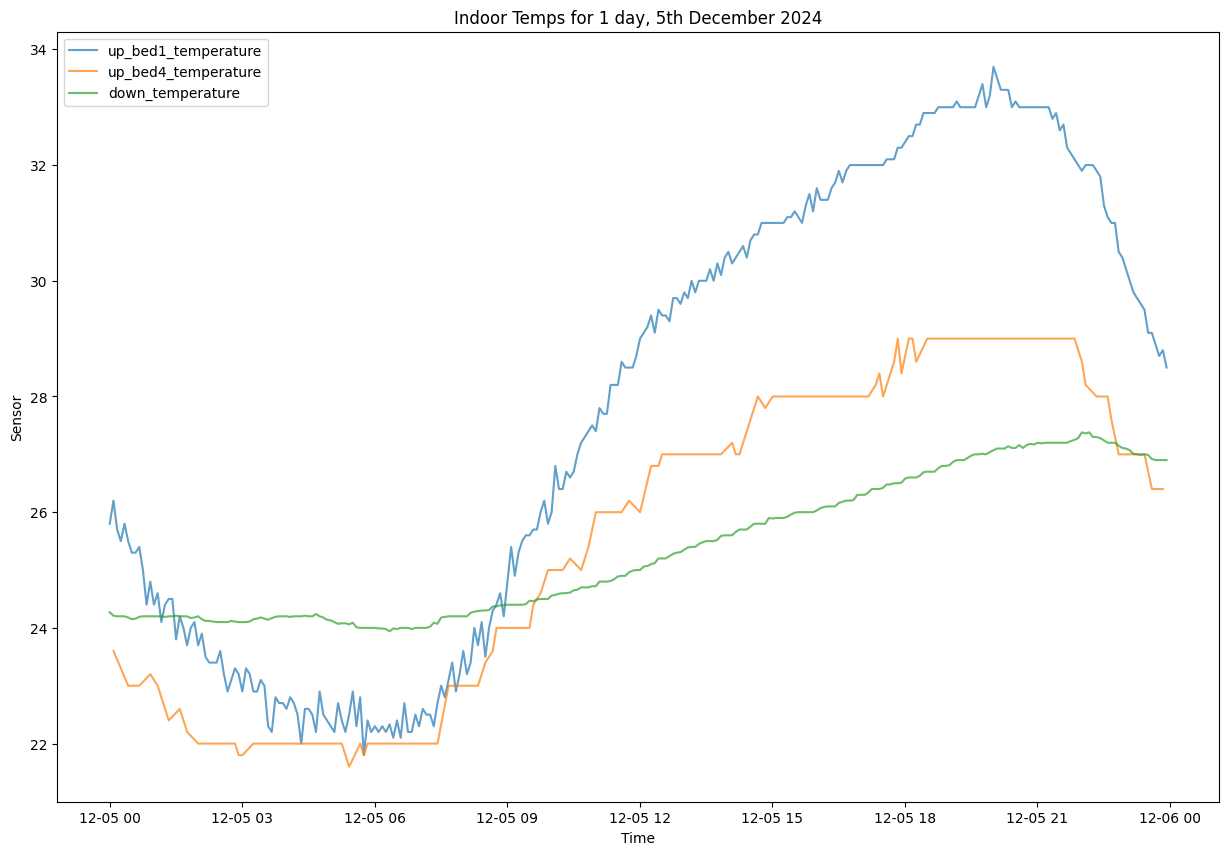

In [219]:
# show internal temperature during the chosen hot day
day_of_year=340
day_data = df.query(f'year==2024 & day_of_year=={day_of_year}')
#print(day_data.head(2))
# Create time series plots for each sensor (column)
plt.figure(figsize=(15, 10))
# matplotlib does not seem to handle null entries, so remove them before plotting
day_data_plot = day_data[['created_at','up_bed1_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['up_bed1_temperature'], label='up_bed1_temperature', alpha=0.7)
day_data_plot = day_data[['created_at','up_bed4_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['up_bed4_temperature'], label='up_bed4_temperature', alpha=0.7)
day_data_plot = day_data[['created_at','down_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['down_temperature'], label='down_temperature', alpha=0.7)
#df = df[~df['my_col'].isnull()]
plt.xlabel('Time')
plt.ylabel('Sensor')
plt.title(f"Indoor Temps for 1 day, 5th December 2024")
plt.legend()
plt.show()
#print(day_data_cols['up_bed1_temperature'])

In [220]:
all_hot_days = pd.DataFrame(columns=['year','day_of_year','Maximum temperature (Degree C)'])
#find a hot day in each year
for year in years:
    if year > 2021:  #Note: remove this filter if we want all years
        outdoor_df = locals()[f'outside_{year}_df']
        outdoor_df['day_of_year'] = range(1,len(outdoor_df)+1)  # add the "day_of_year" column
        outdoor_df['year'] = year
        hot_days = outdoor_df.query('`Maximum temperature (Degree C)` > 40')
        print(f"Hot days over 40 degrees in year {year} are: {hot_days}")
        all_hot_days = pd.concat([all_hot_days, hot_days[['year','day_of_year','Maximum temperature (Degree C)']]], ignore_index=True, sort=False)
        

Hot days over 40 degrees in year 2022 are:     Product code  Bureau of Meteorology station number  Year  Month  Day  \
10    IDCJAC0010                                 23000  2022      1   11   
360   IDCJAC0010                                 23000  2022     12   27   

     Maximum temperature (Degree C)  \
10                             40.3   
360                            41.0   

     Days of accumulation of maximum temperature Quality  day_of_year  year  
10                                             1       Y           11  2022  
360                                            1       Y          361  2022  
Hot days over 40 degrees in year 2023 are:     Product code  Bureau of Meteorology station number  Year  Month  Day  \
13    IDCJAC0010                                 23000  2023      1   14   
53    IDCJAC0010                                 23000  2023      2   23   
313   IDCJAC0010                                 23000  2023     11   10   

     Maximum temperature (De

C:\Users\jon3d\AppData\Local\Temp\ipykernel_50440\2891004021.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_hot_days = pd.concat([all_hot_days, hot_days[['year','day_of_year','Maximum temperature (Degree C)']]], ignore_index=True, sort=False)


In [221]:
print(all_hot_days)

   year day_of_year  Maximum temperature (Degree C)
0  2022          11                            40.3
1  2022         361                            41.0
2  2023          14                            40.6
3  2023          54                            40.2
4  2023         314                            40.3
5  2024          23                            41.2
6  2024         340                            40.1


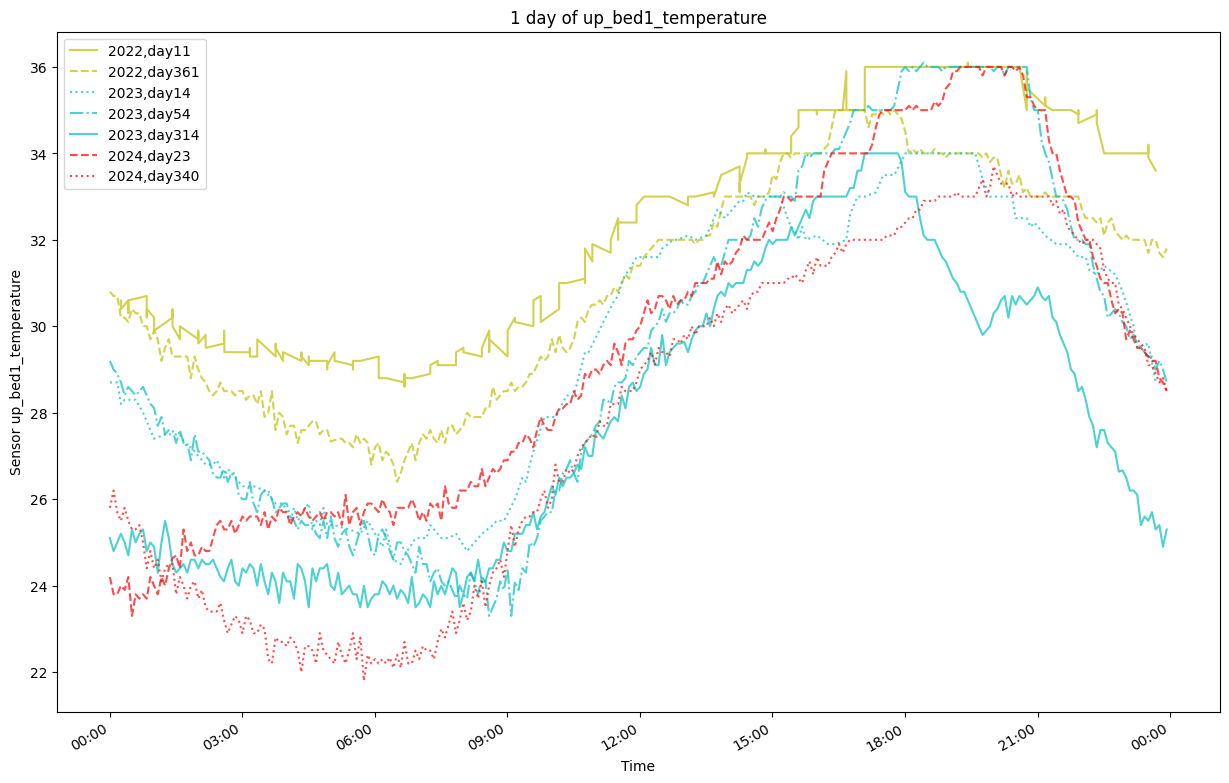

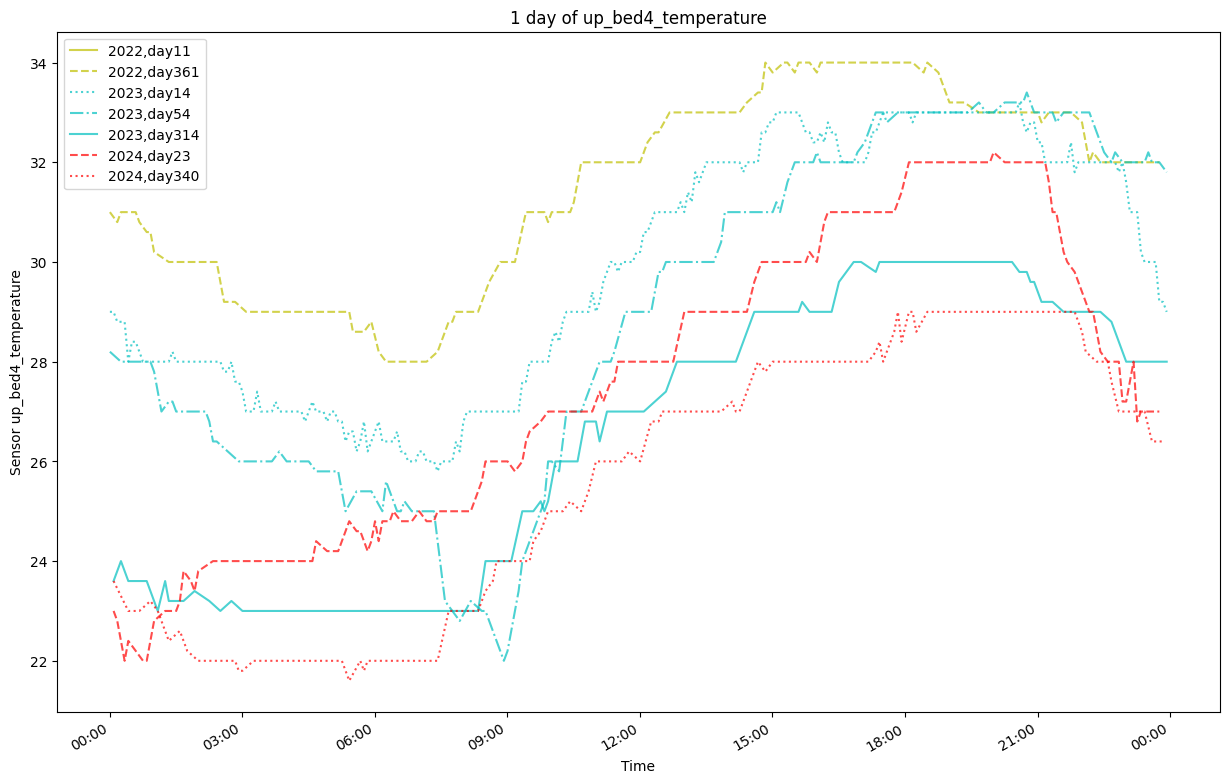

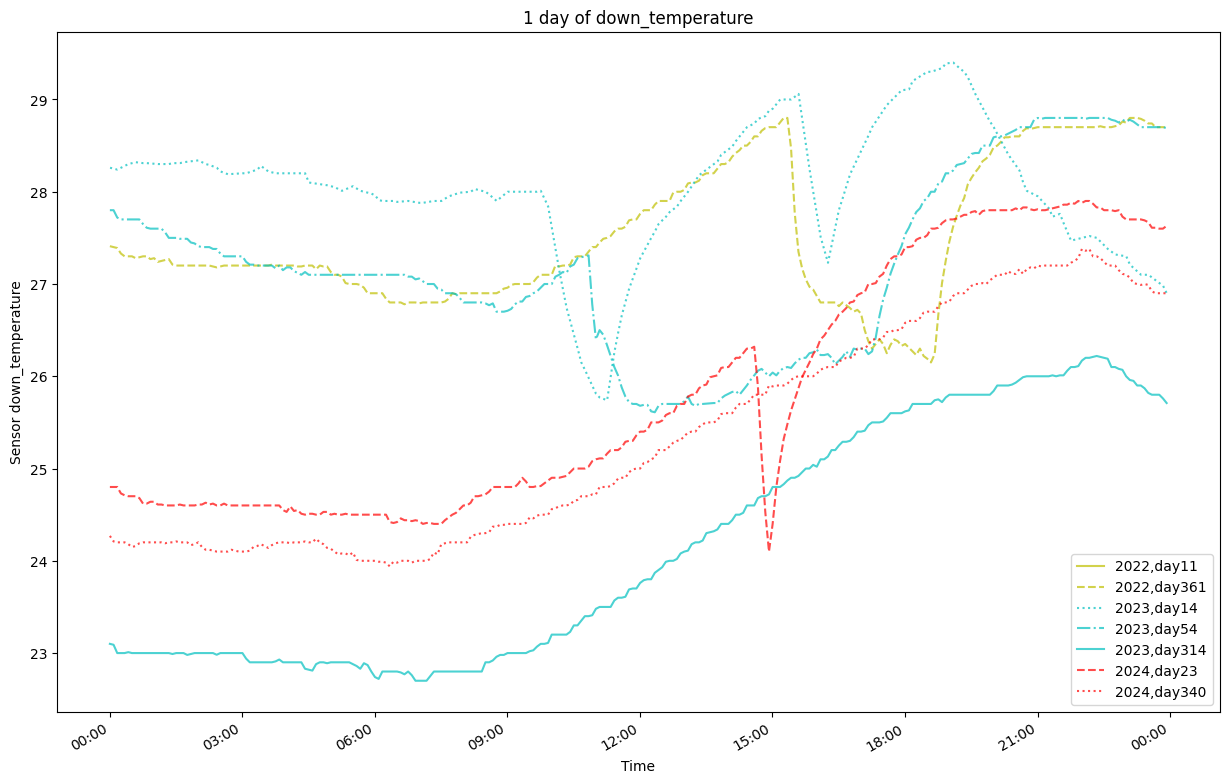

In [222]:
# Plot internal temperature during each of the chosen hot days
import matplotlib.dates as mdates
from cycler import cycler
from matplotlib import lines
import random
mpl.rcParams['timezone'] = 'Australia/Adelaide'

cc = cycler(linestyle=['-', '--', ':', '-.'])

for sensor_name in ['up_bed1_temperature', 'up_bed4_temperature', 'down_temperature']:
    # Create time series plots for each sensor on the chosen days
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(cc)
    timeFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(timeFmt)
    
    for idx, row in all_hot_days.iterrows():
        year = row['year']
        day_of_year = row['day_of_year']
        day_data = df.query(f'year=={year} & day_of_year=={day_of_year}')
        #print(day_data.head(2))
    
        if year == 2019:
            f_col = 'g'
        elif year == 2020:
            f_col = 'b'
        if year == 2021:
            f_col = 'm'
        elif year == 2022:
            f_col = 'y'
        if year == 2023:
            f_col = 'c'
        elif year == 2024:
            f_col = 'r'
    
        day_data_plot = day_data[['time_of_day',sensor_name]].dropna().sort_values(by=['time_of_day'], ascending=True)
        #color_fmt = random.choice(cc[f'{year}'])
        #print(color_fmt)
        #ax.set_prop_cycle(cc[f'{year}'])
        ax.plot(day_data_plot['time_of_day'], day_data_plot[sensor_name], label=f'{year},day{day_of_year}', alpha=0.7, color=f_col)
        #day_data_plot = day_data[['created_at','up_bed4_temperature']].dropna()
        #plt.plot(day_data_plot['created_at'], day_data_plot['up_bed4_temperature'], label='up_bed4_temperature', alpha=0.7)
        #day_data_plot = day_data[['created_at','down_temperature']].dropna()
        #plt.plot(day_data_plot['created_at'], day_data_plot['down_temperature'], label='down_temperature', alpha=0.7)
    
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    plt.xlabel('Time')
    plt.ylabel(f'Sensor {sensor_name}')
    plt.title(f"1 day of {sensor_name}")
    plt.legend()
    plt.show()

Intepretation:
- up_bed1 is about 2 degrees warmer than up_bed4 on these hot days.  Perhaps this is becaause up_bed1 is facing NNW.
- Note: up_bed1 sensor has a PIR, and that is located in the upstairs study which faces NNW.  It has 1m elevation above the floor. No airconditioning. In perhaps 2019-2021 it was located in Josh's room with aircon.
- Note: up_bed4 sensor is in the spare room upstairs facing east, 10cm elevation from the floor.  It receives sun in the morning, but no sun by mid afternoon.  No aircon.  In perhaps 2019-2021 it was located in Sylvia's room with aircon.
- for up_bed1, 2019 and 2020 inside temperatures are more mild and stable.  But this may be due to airconditioning.  We see some temperatures decrease at midday which only makes sense with airconditioning.
- there are less hot days in 2023 and 2024, but the inside temperature on those days is higher than earlier years.  It appears no airconditioning was used the the temperature just climbs steadily.  This may tell us more about our aircon habits than about insulation and home improvments?
- Downstairs indoor temperature never exceeds 30 degrees.  But we see the effect of the airconditioner much more.  Perhaps that is because the aircon blows almost directly onto the sensor in the lounge room.  So the temp oscillates a lot!

 - the December 2024 temperatures recorded by up_bed1 and up_bed4 are the lowest for years since 2022.  That could be due to double-glazing upstairs in June 2024.  But not enough data points to confirm that yet.

# Single Day - Cold
for a single day show the rise and fall of temperature, then show after renovations how it rises and falls (both days should have similar outside temp graphs).

In [223]:
#find cold day in 2024
outdoor_df = locals()[f'outside_2024_df']
outdoor_df['day_of_year'] = range(1,len(outdoor_df)+1)  # add the "day_of_year" column
cold_2024 = outdoor_df[outdoor_df['Maximum temperature (Degree C)'] < 13]
cold_2024

Product code  Bureau of Meteorology station number  Year  Month  Day  \
176   IDCJAC0010                                 23000  2024      6   25   
180   IDCJAC0010                                 23000  2024      6   29   
199   IDCJAC0010                                 23000  2024      7   18   
200   IDCJAC0010                                 23000  2024      7   19   

     Maximum temperature (Degree C)  \
176                            12.9   
180                            12.5   
199                            12.9   
200                            12.5   

     Days of accumulation of maximum temperature Quality  day_of_year  year  
176                                            1       N          177  2024  
180                                            1       N          181  2024  
199                                            1       Y          200  2024  
200                                            1       Y          201  2024

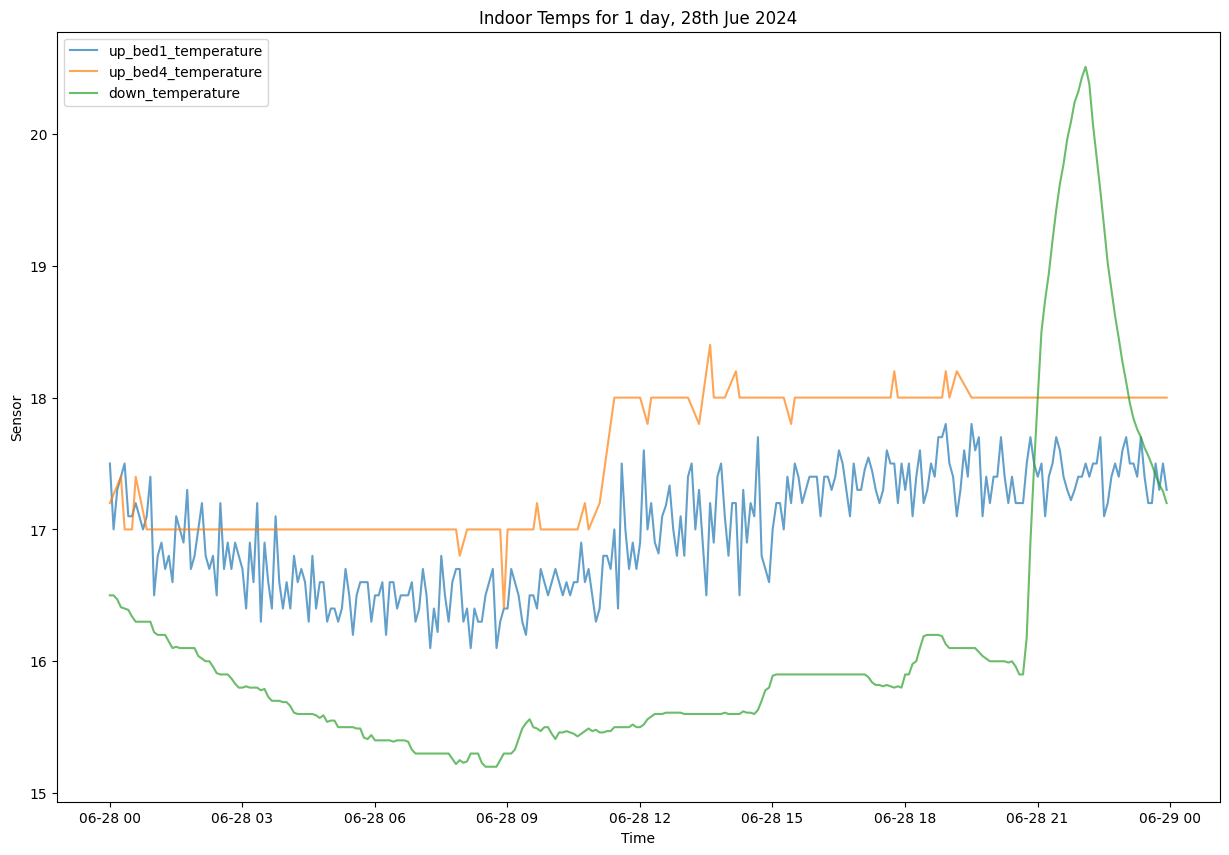

In [224]:
# show internal temperature during the chosen hot day
day_of_year=180
day_data = df.query(f'year==2024 & day_of_year=={day_of_year}')
#print(day_data.head(2))
# Create time series plots for each sensor (column)
plt.figure(figsize=(15, 10))
# matplotlib does not seem to handle null entries, so remove them before plotting
day_data_plot = day_data[['created_at','up_bed1_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['up_bed1_temperature'], label='up_bed1_temperature', alpha=0.7)
day_data_plot = day_data[['created_at','up_bed4_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['up_bed4_temperature'], label='up_bed4_temperature', alpha=0.7)
day_data_plot = day_data[['created_at','down_temperature']].dropna()
plt.plot(day_data_plot['created_at'], day_data_plot['down_temperature'], label='down_temperature', alpha=0.7)
#df = df[~df['my_col'].isnull()]
plt.xlabel('Time')
plt.ylabel('Sensor')
plt.title(f"Indoor Temps for 1 day, 28th Jue 2024")
plt.legend()
plt.show()
#print(day_data_cols['up_bed1_temperature'])

The single day graph shows that downstairs is a couple of degrees colder than upstairs for most of the day.
At 9pm we put a heater on downstairs.

In [225]:
all_cold_days = pd.DataFrame(columns=['year','day_of_year','Maximum temperature (Degree C)'])
#find a hot day in each year
for year in years:
    if year > 2021:  #Note: remove this filter if we want all years
        outdoor_df = locals()[f'outside_{year}_df']
        outdoor_df['day_of_year'] = range(1,len(outdoor_df)+1)  # add the "day_of_year" column
        outdoor_df['year'] = year
        cold_days = outdoor_df.query('`Maximum temperature (Degree C)` < 13')
        print(f"Cold days below 13 degrees in year {year} are: {cold_days}")
        all_cold_days = pd.concat([all_cold_days, cold_days[['year','day_of_year','Maximum temperature (Degree C)']]], ignore_index=True, sort=False)

Cold days below 13 degrees in year 2022 are:     Product code  Bureau of Meteorology station number  Year  Month  Day  \
155   IDCJAC0010                                 23000  2022      6    5   
199   IDCJAC0010                                 23000  2022      7   19   

     Maximum temperature (Degree C)  \
155                            12.7   
199                            11.2   

     Days of accumulation of maximum temperature Quality  day_of_year  year  
155                                            1       Y          156  2022  
199                                            1       Y          200  2022  
Cold days below 13 degrees in year 2023 are:     Product code  Bureau of Meteorology station number  Year  Month  Day  \
172   IDCJAC0010                                 23000  2023      6   22   
177   IDCJAC0010                                 23000  2023      6   27   

     Maximum temperature (Degree C)  \
172                            12.9   
177                   

C:\Users\jon3d\AppData\Local\Temp\ipykernel_50440\3101165947.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_cold_days = pd.concat([all_cold_days, cold_days[['year','day_of_year','Maximum temperature (Degree C)']]], ignore_index=True, sort=False)


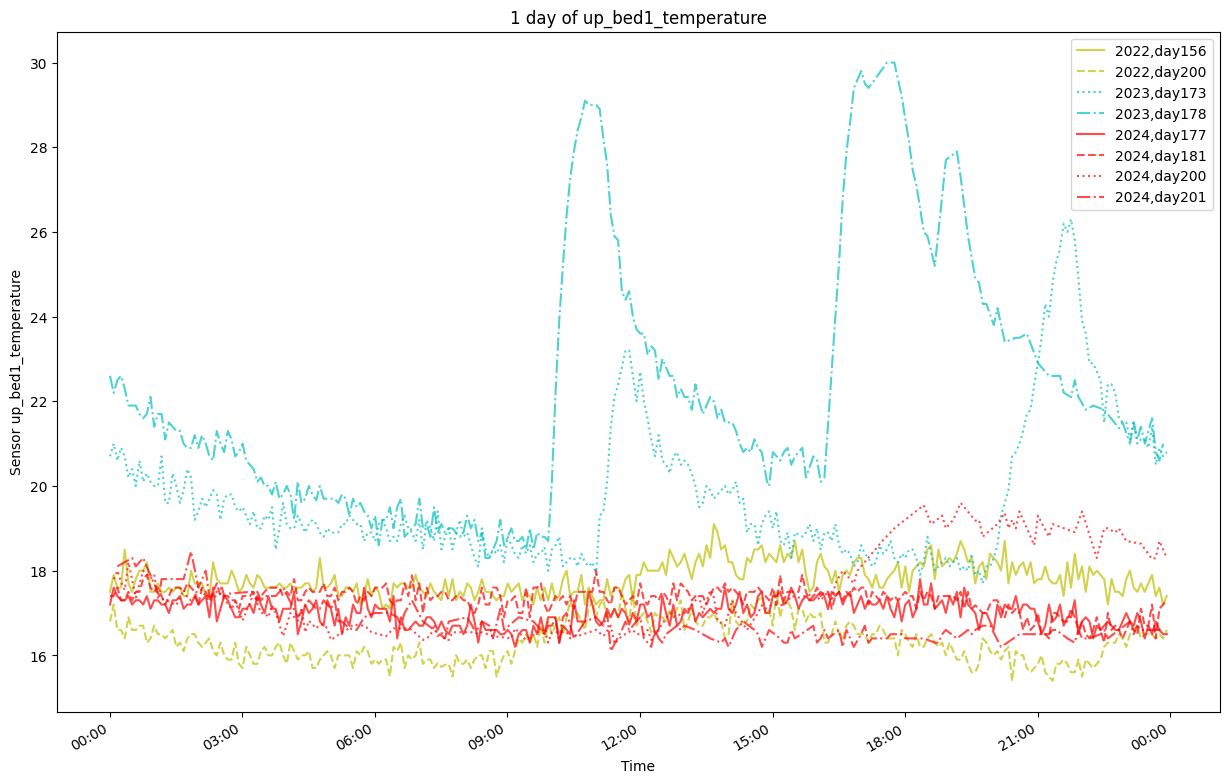

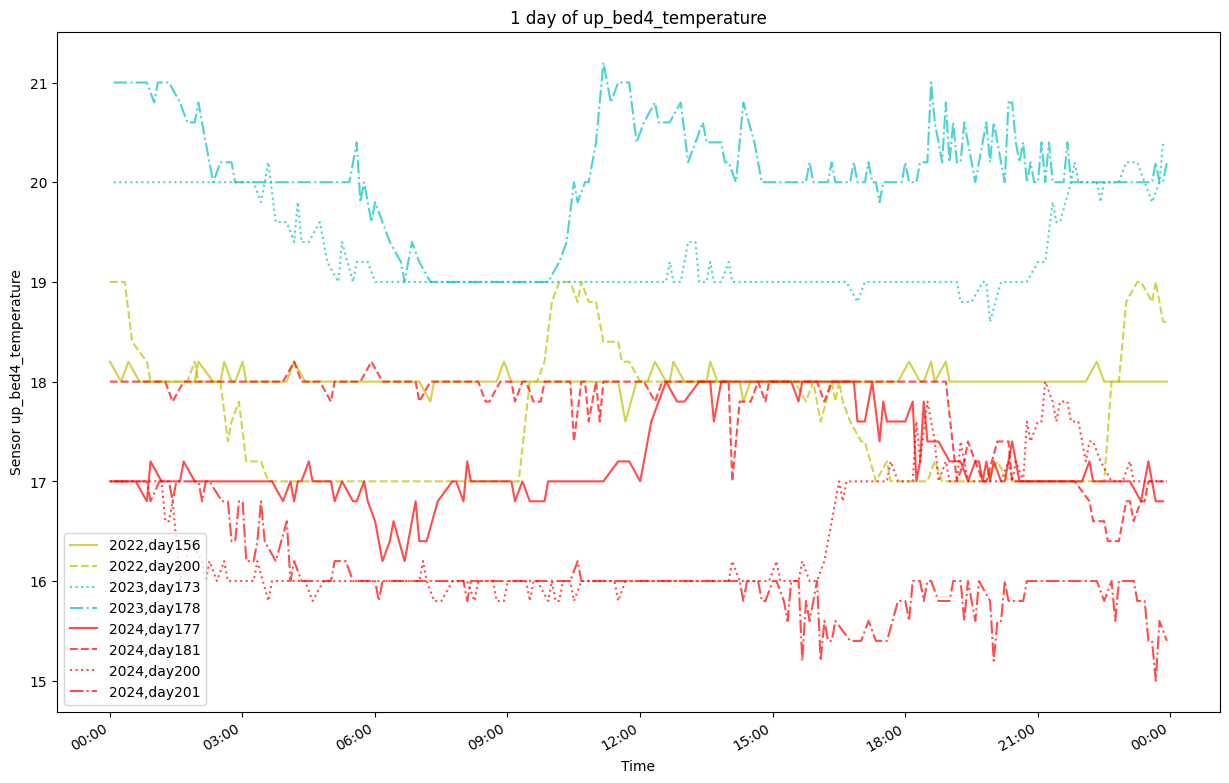

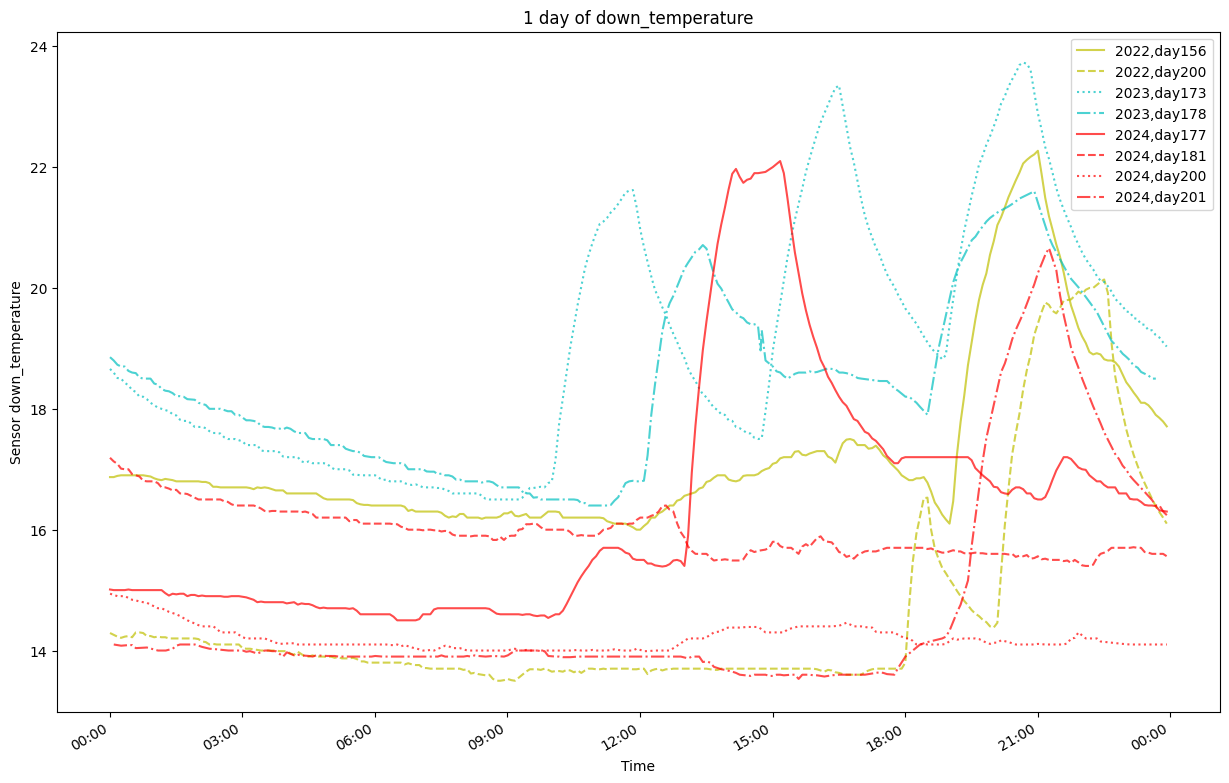

In [226]:
# Plot internal temperature during each of the chosen cold days
import matplotlib.dates as mdates
from cycler import cycler
from matplotlib import lines
import random
mpl.rcParams['timezone'] = 'Australia/Adelaide'

cc = cycler(linestyle=['-', '--', ':', '-.'])

for sensor_name in ['up_bed1_temperature', 'up_bed4_temperature', 'down_temperature']:
    # Create time series plots for each sensor on the chosen days
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(cc)
    timeFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(timeFmt)
    
    for idx, row in all_cold_days.iterrows():
        year = row['year']
        day_of_year = row['day_of_year']
        day_data = df.query(f'year=={year} & day_of_year=={day_of_year}')
        #print(day_data.head(2))
    
        if year == 2019:
            f_col = 'g'
        elif year == 2020:
            f_col = 'b'
        if year == 2021:
            f_col = 'm'
        elif year == 2022:
            f_col = 'y'
        if year == 2023:
            f_col = 'c'
        elif year == 2024:
            f_col = 'r'
    
        day_data_plot = day_data[['time_of_day',sensor_name]].dropna().sort_values(by=['time_of_day'], ascending=True)
        ax.plot(day_data_plot['time_of_day'], day_data_plot[sensor_name], label=f'{year},day{day_of_year}', alpha=0.7, color=f_col)
        
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    plt.xlabel('Time')
    plt.ylabel(f'Sensor {sensor_name}')
    plt.title(f"1 day of {sensor_name}")
    plt.legend()
    plt.show()

up_bed_1 temperatures on a cold day < 13 degrees outside are consistently about 18 degrees inside even without heating.  Nothing seems to have changed between 2022 and 2024 lines.
Up_bed_4 temperatures are similar in 2022 and 2024, although 2024 appears a degree colder for some reason.  2023 does not count as we can see heating was used upstairs on those days.
down_temperatuure is generally cooler than upstairs.  We can see the use of a heater.  But heat is lost relatively quickly once the heater is turned off.

Date of double glazing upstairs = finished by June 16 = day 168.
Date of roller shutter blinds upstairs = sometime around June 2021

TODO: look at upstairs temperature for a week either side of the installation

# Data checking

In [169]:
print(df_hourly_up_bed1_temperature.head(4))

   year  month  day  day_of_year  hour  up_bed1_temperature
0  2019      4    8           98     0            23.000000
1  2019      4    8           98     1            22.583333
2  2019      4    8           98     2            21.666667
3  2019      4    8           98     3            21.000000


In [170]:
print(openmeteo_outside_2024_df.head(4))

                       time  temperature_2m                 timelocal  year  \
0 2024-01-01 00:00:00+00:00            25.3 2024-01-01 10:30:00+10:30  2024   
1 2024-01-01 01:00:00+00:00            27.4 2024-01-01 11:30:00+10:30  2024   
2 2024-01-01 02:00:00+00:00            27.5 2024-01-01 12:30:00+10:30  2024   
3 2024-01-01 03:00:00+00:00            28.0 2024-01-01 13:30:00+10:30  2024   

   month  day  hour  day_of_year               time_of_day  
0      1    1    10            1 1990-01-01 10:30:00+10:30  
1      1    1    11            1 1990-01-01 11:30:00+10:30  
2      1    1    12            1 1990-01-01 12:30:00+10:30  
3      1    1    13            1 1990-01-01 13:30:00+10:30  


In [171]:
print(df.head(4))

                 created_at  entry_id  up_bed1_temperature  up_bed1_humidity  \
0 2019-04-08 00:44:10+09:30         1                  NaN               NaN   
1 2019-04-08 00:45:11+09:30         2                  NaN               NaN   
2 2019-04-08 00:46:12+09:30         3                  NaN               NaN   
3 2019-04-08 00:47:12+09:30         4                  NaN               NaN   

   up_bed1_pir  up_bed4_temperature  up_bed4_humidity  down_temperature  \
0          NaN                  NaN               NaN               NaN   
1          NaN                  NaN               NaN               NaN   
2          NaN                  NaN               NaN               NaN   
3          NaN                  NaN               NaN               NaN   

   down_humidity  latitude  longitude  elevation  status  year  month  day  \
0            NaN       NaN        NaN        NaN     NaN  2019      4    8   
1            NaN       NaN        NaN        NaN     NaN  2019     

C:\Users\jon3d\AppData\Local\Temp\ipykernel_50440\2401174809.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indoor_data['created_at'] = pd.to_datetime(indoor_data[['year','month','day','hour']])


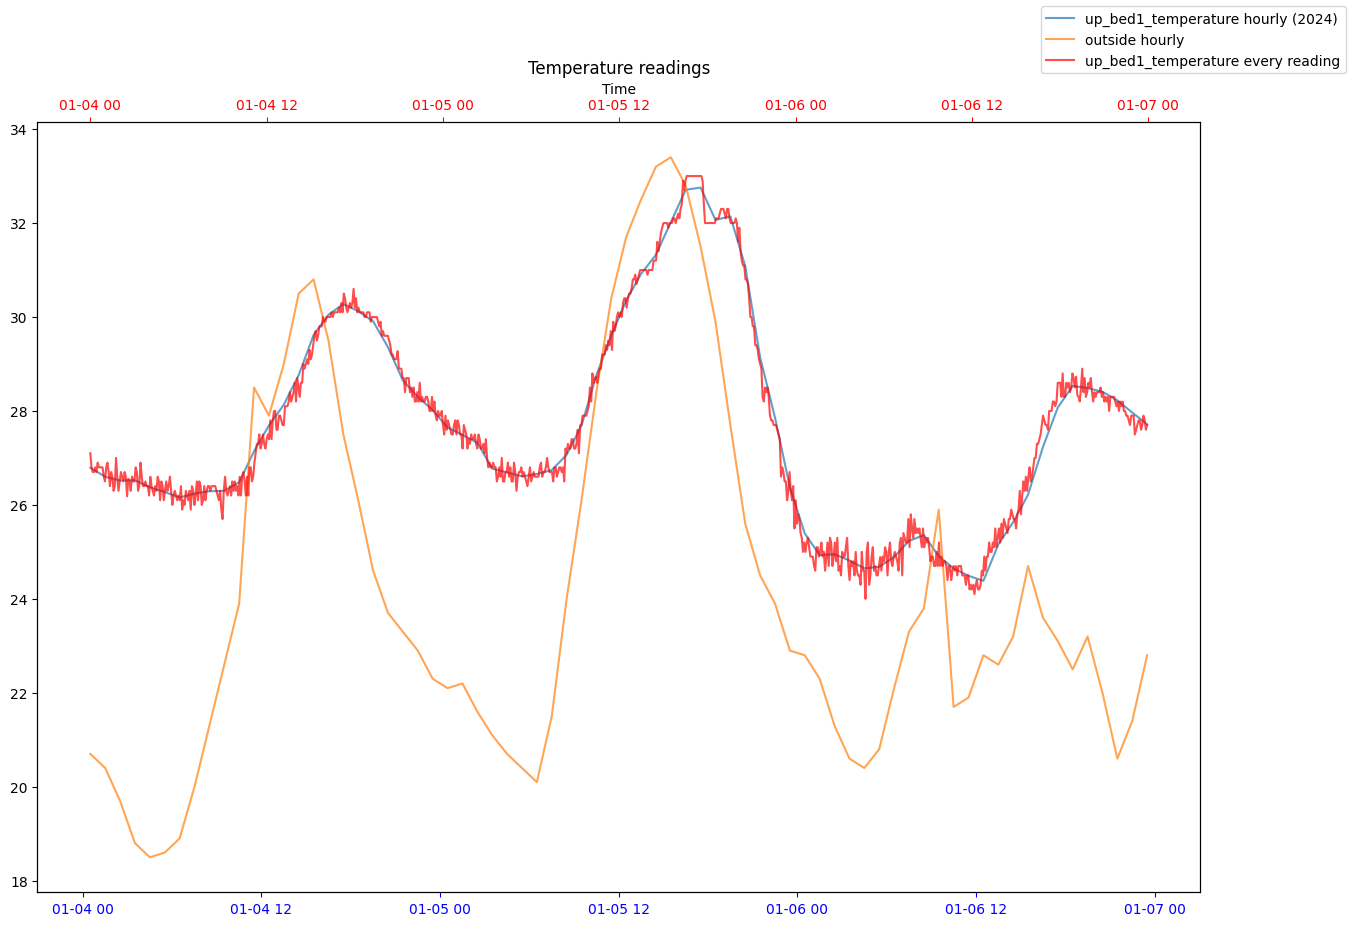

In [228]:
# check hourly averages verses actual readings in a plot
for sensor_name in ['up_bed1_temperature']:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot( 1, 1, 1 )
    tx = ax.twiny()
    tx.tick_params(axis='x', colors='red')
    ax.tick_params(axis='x', colors='blue')
    #for year in years:
    for year in [2024]:
        # Get hourly indoor temps (columns are year, day_of_year, hour)
        indoor_all_df = locals()[f'df_hourly_{sensor_name}']
        indoor_data = indoor_all_df[indoor_all_df['year'] == year]
        indoor_data['created_at'] = pd.to_datetime(indoor_data[['year','month','day','hour']])
        
        # Max outdoor temp
        outdoor_df = locals()[f'openmeteo_outside_{year}_df']
        merged = pd.merge(left=indoor_data, right=outdoor_df, how='left', left_on=['day_of_year','hour'], right_on=['day_of_year','hour']).dropna()
        #print(merged.head(10))
        merged = merged.query('month_x == 1 & day_x > 3 & day_x < 7')
        ax.plot(merged['timelocal'], merged[sensor_name], label=f"{sensor_name} hourly ({year})", alpha=0.7)
        ax.plot(merged['timelocal'], merged['temperature_2m'], label="outside hourly", alpha=0.7)
        
        # Get every indoor reading
        indoor_every = df.query(f'year=={year}')[['created_at',sensor_name, 'year', 'month', 'day']].dropna()
        indoor_every = indoor_every.query('month == 1 & day > 3 & day < 7')
        tx.plot(indoor_every['created_at'], indoor_every[sensor_name], label=f"{sensor_name} every reading", alpha=0.7, color="r")
        
        
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature readings')
fig.legend()
plt.show()

GOOD: So the hourly values are a nice average of the noisy temperature readings every 5 minutes.

BUT: Why did I previouslysee that the inside temp sometimes was as high as the outside max temp???

# Variance

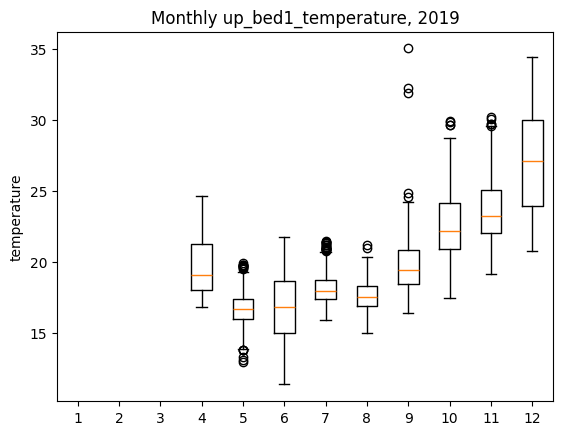

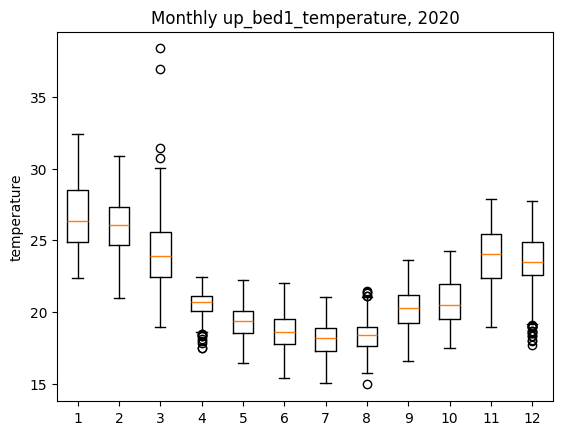

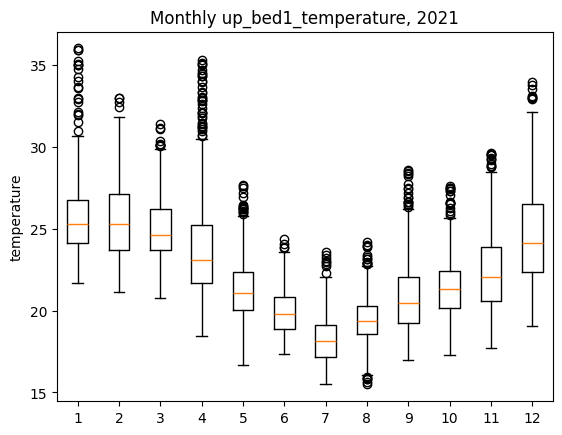

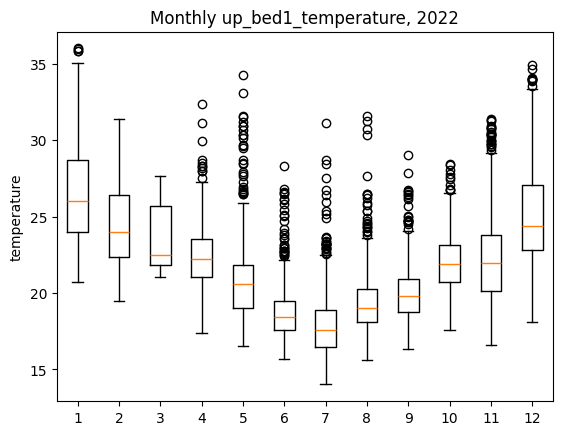

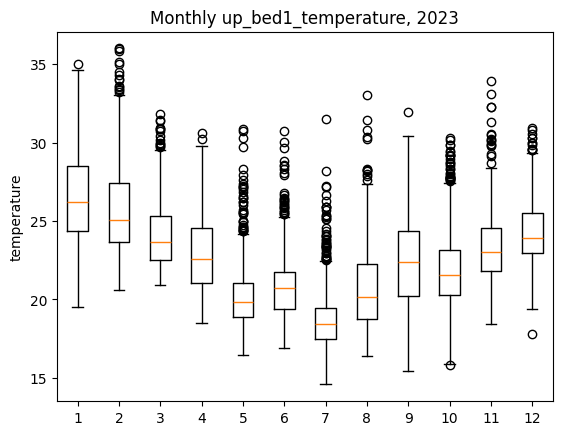

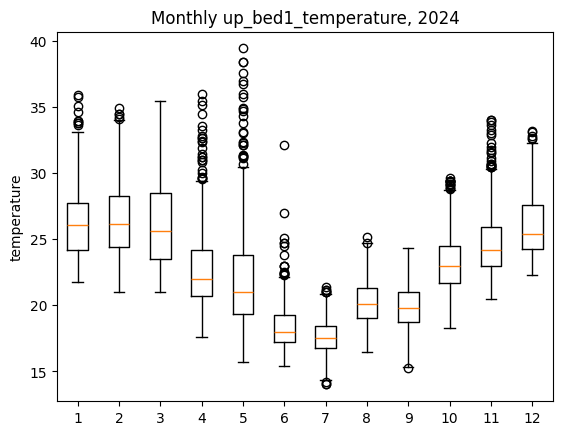

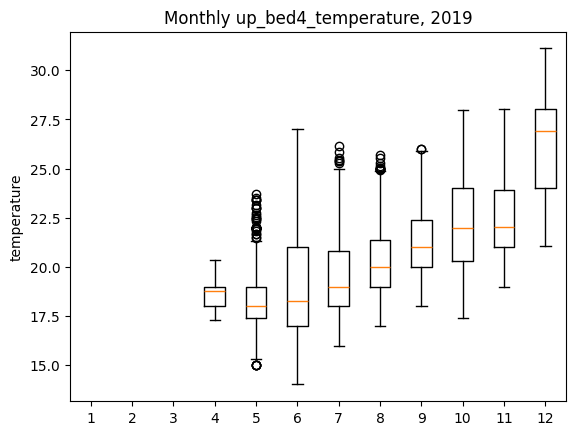

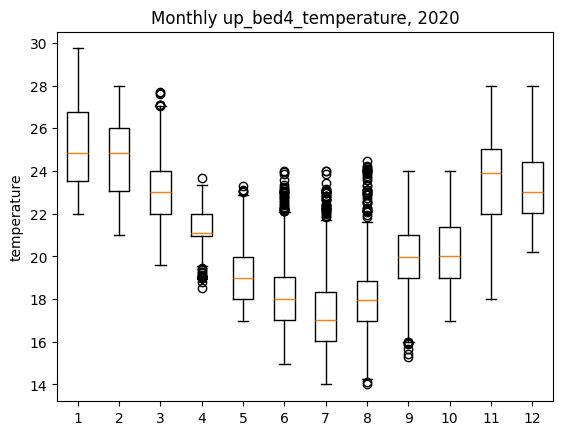

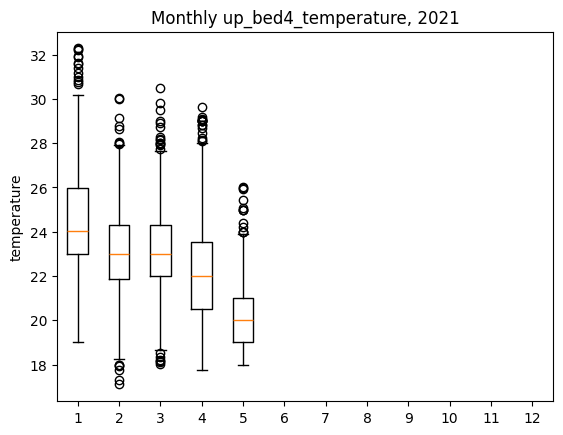

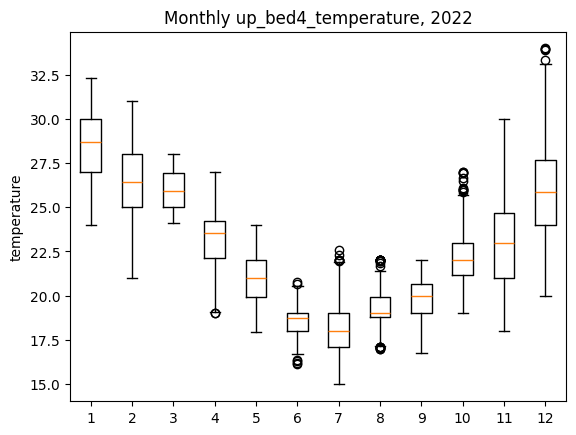

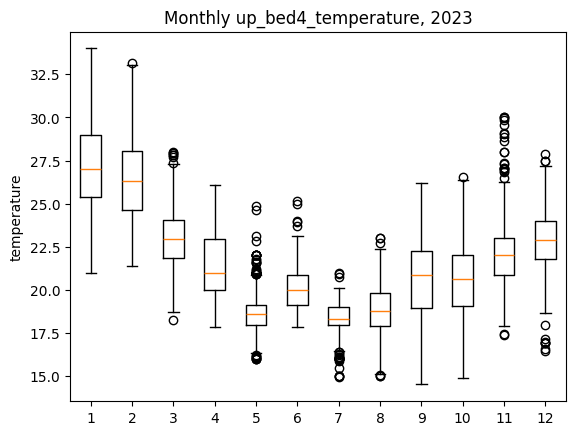

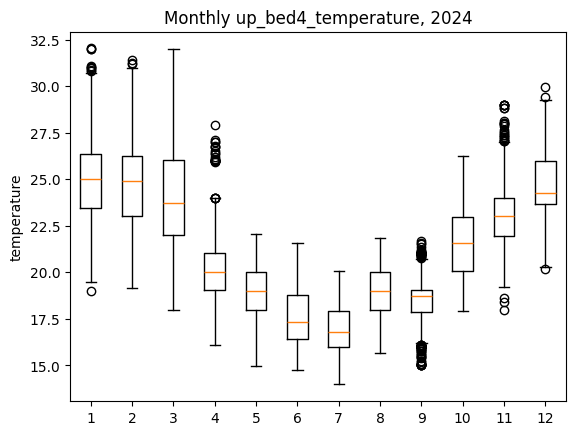

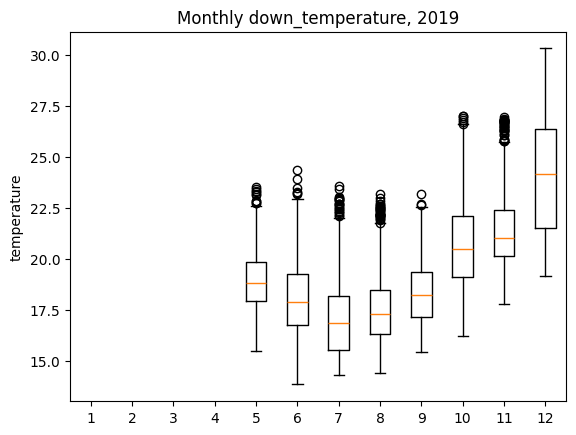

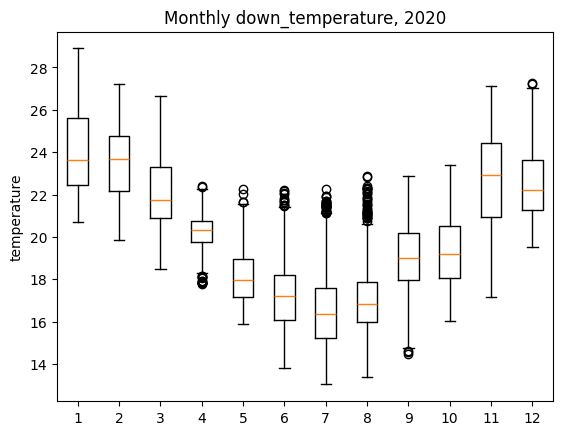

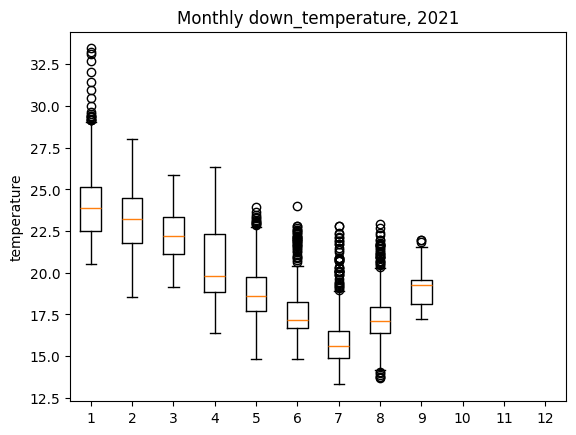

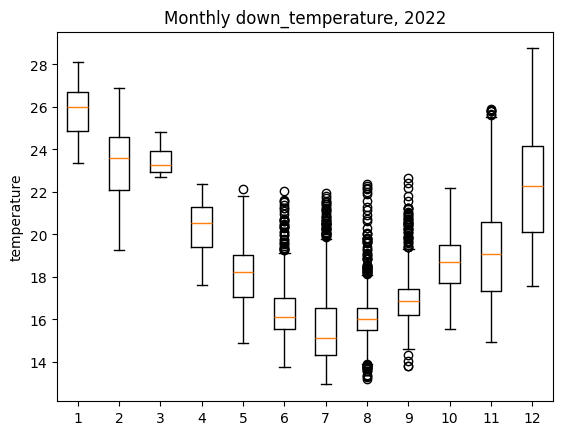

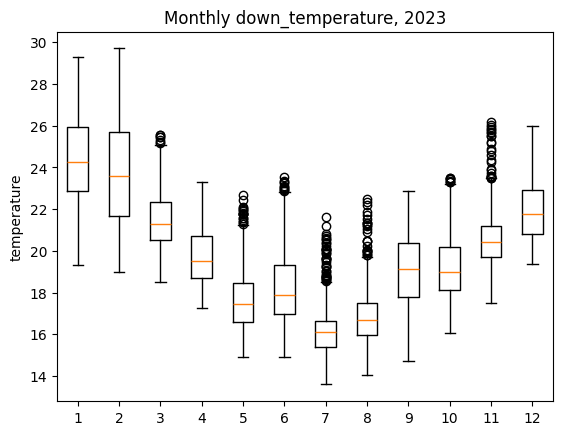

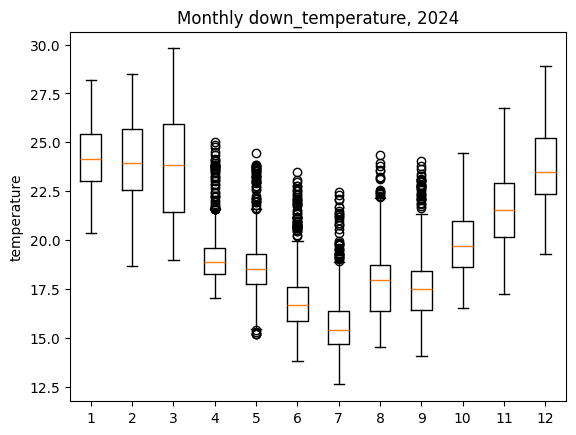

In [205]:
# Plot the variance of hourly temperatures.  Show that variance decreases when we get double glazing.
# Best ways to show variance is either to plot all the data, or do boxplots.
# Here we use boxplots.  To see all the data, look 
# check hourly averages verses actual readings in a plot
for sensor_name in ['up_bed1_temperature','up_bed4_temperature','down_temperature']:
    #for year in years:
    for year in [2023,2024]:
        fig, ax = plt.subplots()
        # Get hourly indoor temps (columns are year, day_of_year, hour)
        indoor = locals()[f'df_hourly_{sensor_name}']
        indoor_year = indoor[indoor['year'] == year]
        indoor_months = dict()
        for month in range(1, 13):
            #print(f"month={month}")
            indoor_month = indoor_year.query(f'month=={month}')[sensor_name].dropna()
            #print(indoor_month.head(2))
            indoor_months[month] = indoor_month
        #my_dict = {'ABC': [34.54, 34.345, 34.761], 'DEF': [34.541, 34.748, 34.482]}
        #ax.boxplot(my_dict.values())
        ax.boxplot(indoor_months.values())
        ax.set_xticklabels(indoor_months.keys())
        ax.set_ylabel('temperature')
        plt.title(f'Monthly {sensor_name}, {year}')
        plt.show()
            


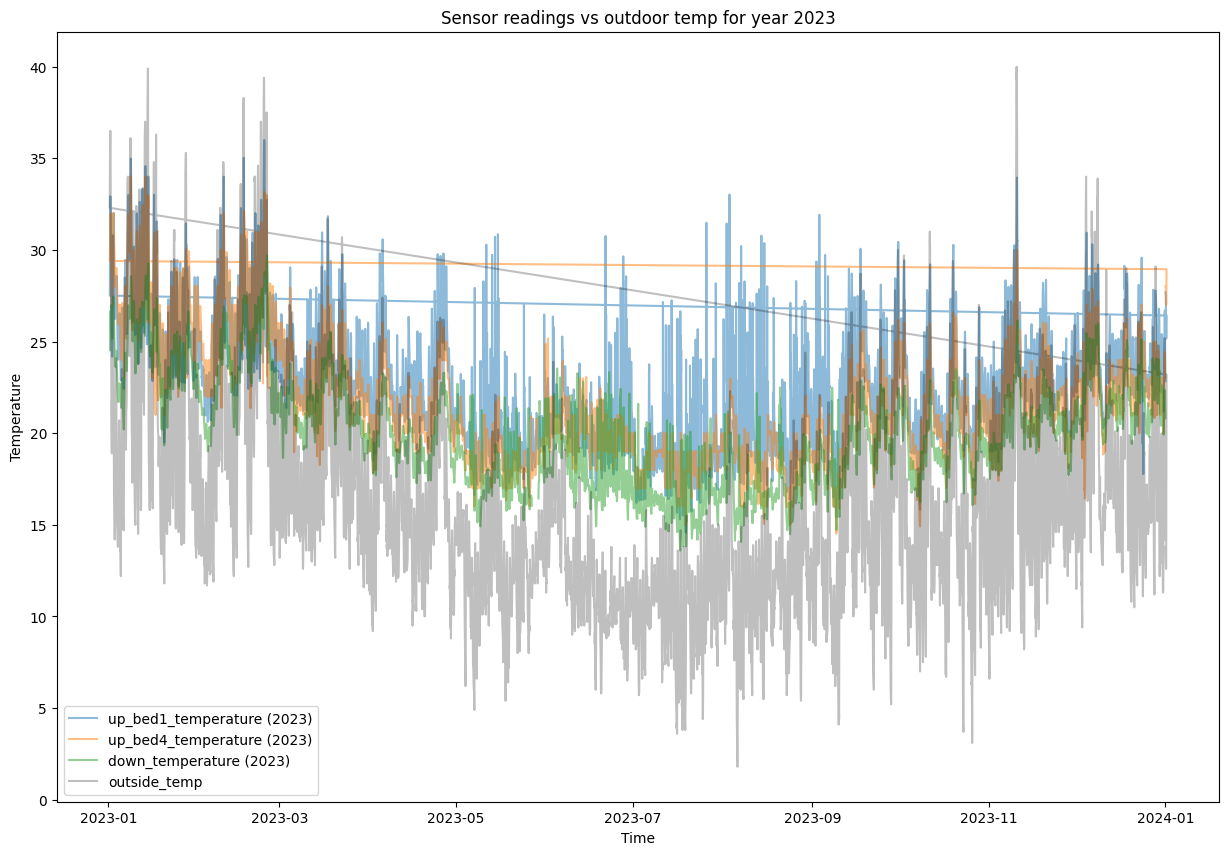

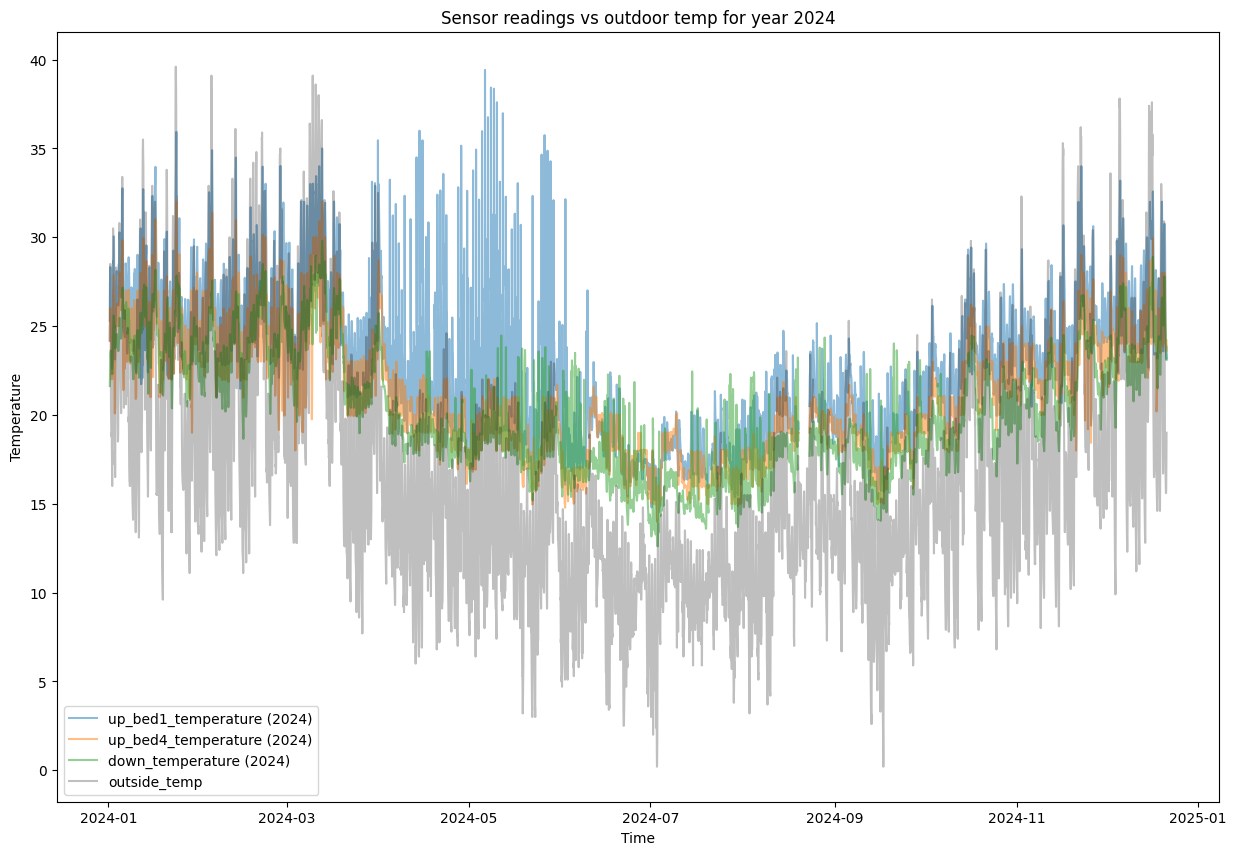

In [216]:
# Plot all data points for hourly temps to see variance visually

#for year in years:
for year in [2023,2024]:
    plt.figure(figsize=(15, 10))
    for sensor_name in ['up_bed1_temperature','up_bed4_temperature','down_temperature']:
    #for sensor_name in ['down_temperature']:
        # Get hourly indoor temps
        indoor_all_df = locals()[f'df_hourly_{sensor_name}']
        indoor_data = indoor_all_df[indoor_all_df['year'] == year]
        #.replace(to_replace=np.nan, value=-99)
        indoor_data_ordered = indoor_data.sort_values(by=['day_of_year','hour'], ascending=True)
        #print(indoor_data_ordered.head(14))
        # outdoor hourly temps
        outdoor_df = locals()[f'openmeteo_outside_{year}_df']
        outdoor_data_ordered = outdoor_df.sort_values(by=['day_of_year','hour'], ascending=True)
        # The indoor and outdoor dataframes may be of different lengths.  Merge them based on their hourly timestamp
        merged = pd.merge(left=outdoor_data_ordered, right=indoor_data_ordered, how='left', left_on=['day_of_year','hour'], right_on=['day_of_year','hour'])
        plt.plot(merged['timelocal'], merged[sensor_name], label=f"{sensor_name} ({year})", alpha=0.5)
    plt.plot(merged['timelocal'], merged['temperature_2m'], label="outside_temp", alpha=0.25, color="k")
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title(f'Sensor readings vs outdoor temp for year {year}')
    plt.legend()
    plt.show()

The 2024 plot of all sensors shows tat from midyear the temperature variance appears to have decreased for internal temperature sensors.
The plots also show the outside temparature is generally lower than indoor temperature, and indoor temp is more stable.
Downstairs is the coolest indoor temperature, while up_bed1 is the the warmest.
Only 2023 and 2024 have valuable data.


But the question is whether our home improvements have made the house more comfortable
 - plotting only downstairs temperatures over all years shows no discernable difference.  Temps range mainly in 15-25 degrees from 2019 to now.
 - plotting all sensors in 2024 shows some change in june when we got double glazing, but that may be due to moving the sensor around during renovations.

So we have wasted our money?
But subjectively, our house feels more comfortable. What am I missing?

Maybe I should look at aircon usage from power bills?
Maybe just number of hours in comfort range of 15-25 degrees?